# Test results for each property

## Imports and functions

In [34]:
from jarvis.db.jsonutils import dumpjson
from jarvis.db.jsonutils import loadjson
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from SLME import Efficiency
import math
from sklearn.metrics import r2_score
from scipy.integrate import simps


In [35]:
plt.rcParams.update({'font.size': 14,'font.family': 'Times New Roman','axes.labelsize': 14,'axes.titlesize': 14,'xtick.labelsize': 12,'ytick.labelsize': 12,'mathtext.fontset':'stix'})

In [36]:
def weighted_mean(xs,ys):
    xs = np.array(xs)
    ys = np.array(ys)
    numer = np.sum(xs * ys)
    denom = np.sum(xs)
    return numer/denom

In [37]:
def csv_pred(f_path, s_path=None, scale=True,yu=False):
    if scale:
        if s_path is None:
            s_path = f_path
        s_file = 'scaling_files/'+s_path+'_stats.json'
    if yu:
        f_file = f_path+"/yu_val_preds.csv"
    else:
        f_file = f_path+"/val_preds.csv"
    df = pd.read_csv(f_file)
    id_preds = {}
    for id in df['0'].values:
        row = df.loc[df['0'] ==id].to_numpy().tolist()[0]
        if scale:
            stat_dict = loadjson(s_file)
            mu = np.array(stat_dict['mean/s'])
            sig = np.array(stat_dict['std/s'])
            unscaled = np.array(row[1:]) * sig + mu
            if len(unscaled) == 1:
                try:
                    id_preds[id] = unscaled.item()
                except:
                    id_preds[id] = unscaled
            else:
                id_preds[id] = unscaled
        else:
            vals = row[1:]
            if len(vals) > 1:
                id_preds[id] = vals
            else:
                id_preds[id] = vals[0]
    return id_preds

In [38]:
def get_pred_array(pred_dict, true_dict):
    rows = []
    for id in pred_dict:
        if id in true_dict:
            rows.append([true_dict[id],pred_dict[id]])
    return np.array(rows)

In [39]:
def RMSE(targ, pred):
    se = 0
    for t,p in zip(targ,pred):
        se += (t-p)**2
    mse = se/len(targ)
    root = math.sqrt(mse)
    return root

In [40]:
def MAE(targ, pred):
    mae = 0
    for t,p in zip(targ,pred):
        mae += abs(t-p)
    mae = mae/len(targ)
    return mae

In [41]:
def get_best_fits(pred_array):
    ts = pred_array[:,0]
    ps = pred_array[:,1]
    t_mae = MAE(ts,ps)
    t_mean = np.mean(ts)
    lim = round(max(max(ts),max(ps)))
    xs = np.linspace(0,lim,lim)
    ys=xs
    y_upper = xs+t_mae
    y_lower = xs-t_mae
    SSR_xy = 0
    SST = 0
    SSR_f = 0
    m,b = np.polyfit(ts, ps, 1)
    fit_ps = [b + m*t for t in ts]
    for t,p,f_p in zip(ts,ps,fit_ps):
        SSR_xy += (p-t)**2
        SSR_f += (p-f_p)**2
        SST += (p-np.mean(ps))**2
    R_xy = round(1 - (SSR_xy/SST),2)
    R_f = round(1 - (SSR_f/SST),2)
    b = round(b,1)
    m = round(m,1)
    f_ys = b + m*xs
    y_upper = b + m * xs + t_mae
    y_lower = b + m * xs - t_mae
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(xs,ys,"--k",label=r'R$_{y=x}^2$ = %s' % R_xy)
    ax.plot(xs,f_ys,"--r",label=r'R$_{y=%sx+%s}^2$ = %s' % (m,b,R_f))
    ax.fill_between(xs, y_lower, y_upper,facecolor='grey', interpolate=True,label="MAPE: %s" % (round(t_mae/t_mean,2)))
    ax.scatter(ts,ps,marker="x")
    return fig,ax

In [42]:
def linear_plotter(name,preds,true):
    rows_1 = []
    t_dict = {}
    f_dict = {}
    t_count=0
    for id in preds:
        if id in true:
            if type(true[id]) == dict:
                if type(true[id]) == list:
                    if len(true[id])==0:
                        continue
                    else:
                        value = np.mean(true[id])
                else:
                    value = true[id]
            else:
                value = true[id]
            rows_1.append([value,preds[id]])
            t_dict[id] = t_count
            t_count+=1
    t_array = np.array(rows_1)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(name)
    get_best_fits(t_array,axs,0)
    axs[0].set_xlabel('Source test')
    axs[0].set_ylabel('Predicted')
    axs[0].legend()
    axs[1].set_xlabel('Predicted')
    axs[1].set_xlabel('Fabini test')
    axs[1].legend()
    return t_array,t_dict,f_dict

In [43]:
def spec_plotter(id,preds,trues,title,dims,absorptance = False):
    fig = plt.figure(1,(5,5))
    target = np.array(trues[id])
    pred = preds[id]
    xs = np.linspace(0,5,dims+1)
    if len(pred) == len(target):
        p = pred
        if len(p) == dims:
            xs = np.delete(xs,0,0)
        if len(p) > dims:
            xs = xs
    elif len(target) > len(pred):
        p = np.insert(pred,0,0)
    rmse = round(RMSE(target,p),2)
    mae = round(MAE(target,p),2)
    plt.plot(xs,target,label='target')
    plt.plot(xs,p,label='pred')
    plt.xlabel('Energy /eV')
    plt.ylabel(r'$\alpha$ / cm$^{-1}$')
    plt.legend()
    plt.text(0,mae,f"RMSE is {rmse}\n MAE is {mae}")
    plt.title(title)
    if absorptance:
        plt.ylim(-0.2,1.2)

In [44]:
def cleanup(absorptance):
    As = list(absorptance)
    new_As = []
    for A in As:
        if A <0:
            a = 0
        elif A > 1:
            a = 1
        else:
            a = A
        new_As.append(a)
    return(new_As)

In [45]:
def shifter(pred_dict,diff_dict,mpid,clean=False):
    diff = diff_dict[mpid]
    alphas = pred_dict[mpid]
    if len(alphas) == 100:
        new_alphas = np.append(np.array([0]),alphas)
    else:
        new_alphas = alphas
    alphas = np.array(new_alphas)
    Es = np.linspace(0,5,101)
    shifted_Es = Es+diff
    with_zero = np.insert(shifted_Es,0,0)
    right_length = np.delete(with_zero,-1)
    new_abs=np.interp(Es,right_length,alphas)
    if clean:
        new_abs = cleanup(new_abs)
    return new_abs

In [46]:
def rank(pred_array,id_dict):
    pred = {}
    true = {}
    for id in id_dict:
        index = id_dict[id]
        true[id] = pred_array[index,0]
        pred[id] = pred_array[index,1]
    s_trues = {k: v for k, v in sorted(true.items(), key=lambda item: item[1], reverse = True)}
    s_preds = {k: v for k, v in sorted(pred.items(), key=lambda item: item[1], reverse = True)}
    rank_dict = {}
    diff_dict = {}
    for id in true:
        pred_rank = list(s_preds.keys()).index(id)
        true_rank = list(s_trues.keys()).index(id)
        rank_dict[id] = pred_rank - true_rank
        diff_dict[id] = pred[id] - true[id]
    s_rank_dict = {k: v for k, v in sorted(rank_dict.items(), key=lambda item: item[1], reverse = True)}
    s_diff_dict = {k: v for k, v in sorted(diff_dict.items(), key=lambda item: item[1], reverse = True)}
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("Differences in raw numbers and in rankings")
    axs[0].hist(s_diff_dict.values())
    axs[0].set_xlabel('Raw differences')
    axs[1].hist(s_rank_dict.values())
    axs[1].set_xlabel('Differences in ranks')
    return s_diff_dict, s_rank_dict

In [47]:
def diff_dict(true,pred):
    d = {}
    for id in true:
        if id in pred:
            d[id] = list(true[id] - pred[id])[0]
    return d

In [48]:
def r2_score(y_true, y_pred):
    """
    Calculate the R^2 (coefficient of determination) value between true and predicted values.
    
    Parameters:
        y_true (array-like): Array of true Y values.
        y_pred (array-like): Array of predicted Y values.
        
    Returns:
        float: R^2 value.
    """
    # Calculate the mean of true values
    y_true_mean = np.mean(y_true)
    # Calculate the total sum of squares
    ss_total = np.sum((y_true - y_true_mean) ** 2)
    # Calculate the residual sum of squares
    ss_residual = np.sum((y_true - y_pred) ** 2)
    # Calculate R^2
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [49]:
from mpl_axes_aligner import align

In [50]:
def custom_violin(ax, data, pos, fc='b', ec='k', alpha=1, percentiles=[25, 50, 75], side="both", scatter_kwargs={}, violin_kwargs={}):
    """Customized violin plot.
    ax: axes.Axes, The axes to plot to
    data: 1D array like, The data to plot
    pos: float, The position on the x-axis where the violin should be plotted
    fc: color, The facecolor of the violin
    ec: color, The edgecolor of the violin
    alpha: float, The transparancy of the violin
    percentiles: array like, The percentiles to be marked on the violin
    side: string, Which side(s) of the violin should be cut off. Options: 'left', 'right', 'both'
    scatter_kwargs: dict, Keyword arguments for the scatterplot
    violin_kwargs: dict, Keyword arguments for the violinplot"""

    parts = ax.violinplot(data, positions=[pos], **violin_kwargs)
    for pc in parts['bodies']:
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        if side == "left":
            points_x = pos - 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
        elif side == "right":
            points_x = pos + 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        else:
            points_x = pos
        pc.set_facecolor(fc)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)

    perc = np.percentile(data, percentiles)
    for p in perc:
        ax.scatter(points_x, p, color=ec, zorder=3, **scatter_kwargs)

In [51]:
def absorptance(alphas_dict):
    A_dict = {}
    for mpid, alphas in alphas_dict.items():
        new_alphas = []
        for a in alphas:
            if a<0:
                a = 0
            new_alphas.append(a)
        absorp = 1 - np.exp(-2 * np.array(new_alphas) * 500E-7)
        A_dict[mpid] = absorp
    return A_dict

In [52]:
def plot_array_scatter(axis, dataset, method, array,tolerance,axis_label="offset / eV"):
    axis.scatter(array[:,0],array[:,1])
    axis.set_xlim(np.min(array)-tolerance,np.max(array)+tolerance)
    axis.set_ylim(np.min(array)-tolerance,np.max(array)+tolerance)
    axis.plot([np.min(array)-tolerance,np.max(array)+tolerance],[np.min(array)-tolerance,np.max(array)+tolerance],'--k')
    axis.set_xlabel(f'Test {axis_label}')
    axis.set_ylabel(f'{dataset} ML-Predicted {axis_label}')
    axis.set_title(f'{method}: MAE {MAE(array[:,0], array[:,1]):.2f}')

In [53]:
eff = Efficiency()

## Loading test data

In [54]:
ft_deltas = loadjson('true_values/test_FT_deltas.json')
fab_gap_data = loadjson('Fabini_data/fab_gap_data.json')
fab_deltas = {mpid: fab_gap_data[mpid]['offset'] for mpid in fab_gap_data}
fab_gaps =  {mpid: fab_gap_data[mpid]['fun_gap'] for mpid in fab_gap_data}
yu_deltas = loadjson('Yu_data/Yu_offsets.json')
eta_acts = loadjson('true_values/test_FT_etas.json')
yu_etas = loadjson('Yu_data/Yu_etas.json')
yu_gaps = loadjson('Yu_data/Yu_band_gaps.json')
fab_etas = loadjson('Fabini_data/fab_SLMEs.json')
fab_corrs = loadjson('Fabini_data/fab_delta_sols.json')
alphas_acts = loadjson('true_values/test_alphas.json')
As_acts = loadjson('true_values/test_As.json')
corr_As_acts = loadjson('true_values/test_corr_As.json')
gap_acts = loadjson('true_values/test_gaps.json')
corr_acts = loadjson('true_values/test_corrs.json')

## Internal test results

### Absorption

In [55]:
alphas_preds = csv_pred('alphas')

In [56]:
len(alphas_preds)

1230

In [57]:
xs = np.linspace(0,5,101)

In [58]:
rows = []
for id in alphas_preds:
    if id in alphas_acts:
        row=[weighted_mean(xs,[0]+list(alphas_acts[id])),weighted_mean(xs, [0]+list(alphas_preds[id]))]
        rows.append(row)
absorption_wms= np.array(rows)

In [59]:
np.shape(absorption_wms)

(538, 2)

In [60]:
r2 = r2_score(absorption_wms[:,0], absorption_wms[:,1])

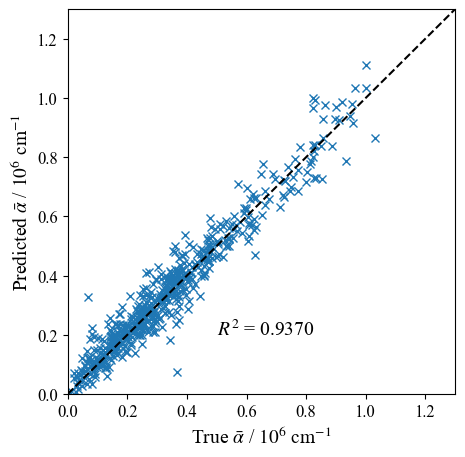

In [61]:
plt.figure(figsize=(5,5))
plt.plot(absorption_wms[:,0]/1E6,absorption_wms[:,1]/1E6,'x')
plt.text(0.5, 0.2, r'$R^2$ = {:.4f}'.format(r2))
plt.plot([0,1.3],[0,1.3],'--k')
plt.xlim(0,1.3)
plt.ylim(0,1.3)
plt.xlabel(r'True $\bar{\alpha}$ / $10^6$ cm$^{-1}$')
plt.ylabel(r'Predicted $\bar{\alpha}$ / $10^6$ cm$^{-1}$')
plt.savefig('alignn_alpha_wm.pdf', bbox_inches='tight')

In [62]:
alphas_maes = {}
for id,pred in alphas_preds.items():
    if id in alphas_acts:
        true = alphas_acts[id]
        alphas_maes[id] = MAE(true,pred)
    

In [63]:
s_alphas_maes = s_trues = {k: v for k, v in sorted(alphas_maes.items(), key=lambda item: item[1], reverse = True)}

In [64]:
worst,best = list(s_alphas_maes.keys())[0],list(s_alphas_maes.keys())[-1]

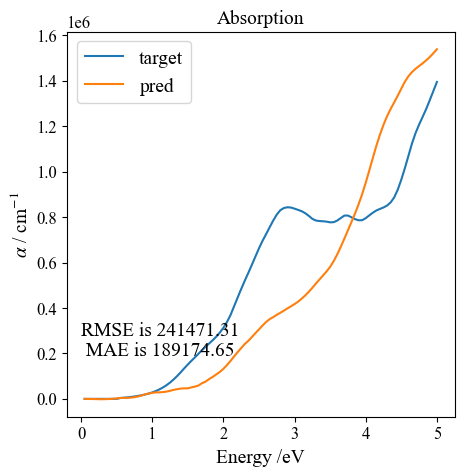

In [65]:
spec_plotter(worst,alphas_preds,alphas_acts,'Absorption',100,False)

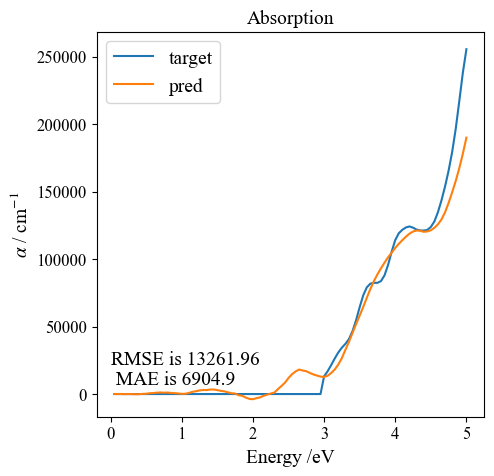

In [66]:
spec_plotter(best,alphas_preds,alphas_acts,'Absorption',100,False)

In [67]:
As_from_alphas = absorptance(alphas_preds)

In [68]:
c_a_As = {k:shifter(As_from_alphas,corr_acts,k) for k in As_from_alphas if k in corr_acts}

In [69]:
Ga_As_alphas = alphas_preds['mp-2534']

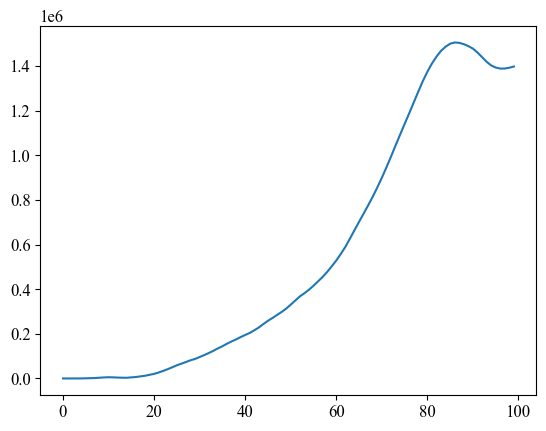

In [70]:
plt.plot(Ga_As_alphas)

In [71]:
energies = list(np.linspace(0,5,101))
energies.pop(0)

0.0

### Absorptance

In [72]:
As_preds = csv_pred('As',scale=False)

In [73]:
As_maes = {}
for id,pred in As_preds.items():
    if id in As_acts:
        true = As_acts[id]
        As_maes[id] = MAE(true,pred)
    

In [74]:
s_As_maes = s_trues = {k: v for k, v in sorted(As_maes.items(), key=lambda item: item[1], reverse = True)}

In [75]:
worst,best = list(s_As_maes.keys())[0],list(s_As_maes.keys())[-1]

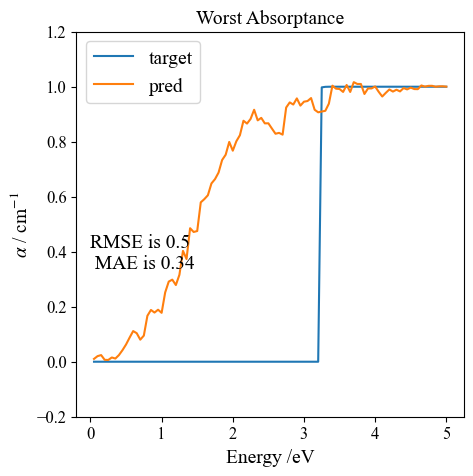

In [76]:
spec_plotter(worst,As_preds,As_acts,'Worst Absorptance',100,True)

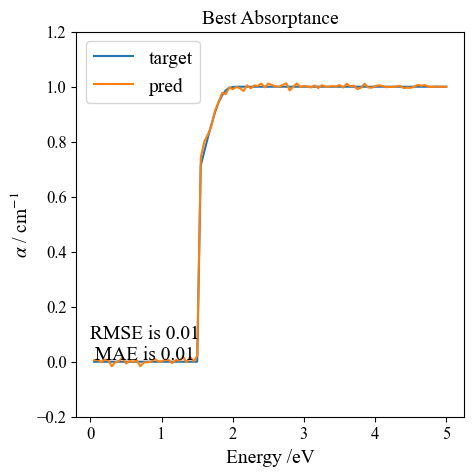

In [77]:
spec_plotter(best,As_preds,As_acts,'Best Absorptance',100,True)

In [78]:
c_As = {k:shifter(As_preds,corr_acts,k,True) for k in As_preds if k in corr_acts}

### Corrected alphas

In [79]:
corr_alphas_preds = csv_pred('corr_alphas')

In [80]:
corr_alphas_As = absorptance(corr_alphas_preds)

### Corrected absorptance

In [81]:
corr_As_preds = csv_pred('corr_As',scale=False)

In [82]:
temps = corr_As_preds
corr_As_preds = {k:cleanup(v) for k,v in temps.items()}

In [83]:
corr_As_maes = {}
for id,pred in corr_As_preds.items():
    if id in corr_As_acts:
        true = corr_As_acts[id]
        corr_As_maes[id] = MAE(true,pred)
        

In [84]:
s_corr_As_maes = s_trues = {k: v for k, v in sorted(corr_As_maes.items(), key=lambda item: item[1], reverse = True)}

In [85]:
worst,best = list(s_corr_As_maes.keys())[0],list(s_corr_As_maes.keys())[-150]

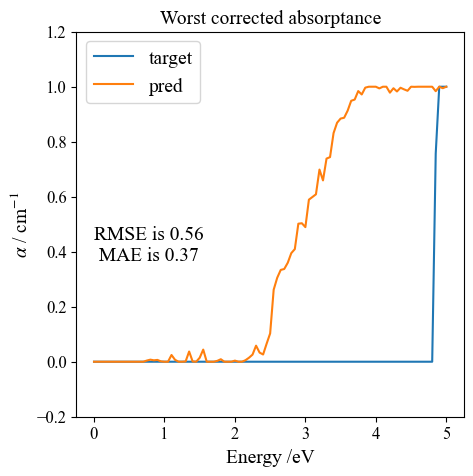

In [86]:
spec_plotter(worst,corr_As_preds,corr_As_acts,'Worst corrected absorptance',100,True)

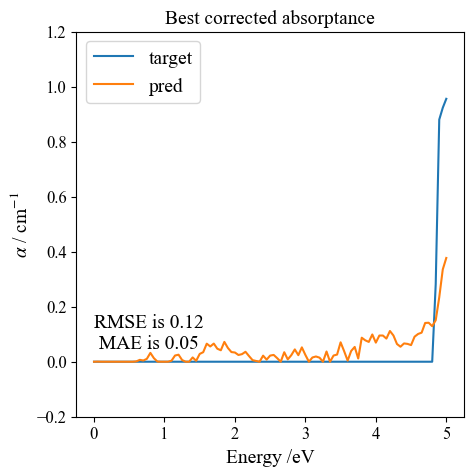

In [87]:
spec_plotter(best,corr_As_preds,corr_As_acts,'Best corrected absorptance',100,True)

### Scissor correction

In [88]:
corr_preds = csv_pred('corrs')
yu_corr_preds = csv_pred('corrs','corrs',yu=True)

In [89]:
corr_arr = get_pred_array(corr_preds,corr_acts)
fab_corr_arr = get_pred_array(corr_preds, fab_corrs)

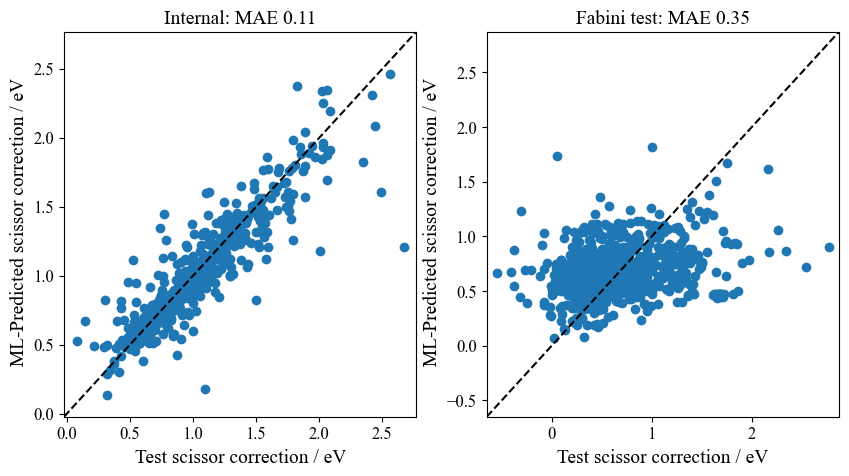

In [90]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
plot_array_scatter(axs[0],'', 'Internal', corr_arr,0.1,'scissor correction / eV')
plot_array_scatter(axs[1],'', 'Fabini test', fab_corr_arr,0.1,'scissor correction / eV')

### Offset $(\Delta E)$

In [91]:
ft_delta_preds = csv_pred('FT_deltas')
ft_u_delta_preds = csv_pred('FT_deltas_unscaled',scale=False)
ft_zi_delta_preds = csv_pred('FT_deltas_unscaled/ZI',scale=False)
yu_ft_delta_preds = csv_pred('FT_deltas',yu=True)
yu_ft_delta_preds = {str(k):v for k,v in yu_ft_delta_preds.items()}
yu_ft_u_delta_preds = csv_pred('FT_deltas_unscaled',scale=False,yu=True)
yu_ft_u_delta_preds = {str(k):v for k,v in yu_ft_u_delta_preds.items()}
yu_ft_zi_delta_preds = csv_pred('FT_deltas_unscaled/ZI',scale=False,yu=True)
yu_ft_zi_delta_preds = {str(k):v for k,v in yu_ft_zi_delta_preds.items()}

In [92]:
ft_delta_array = get_pred_array(ft_delta_preds,ft_deltas)
ft_u_delta_array = get_pred_array(ft_u_delta_preds,ft_deltas)
ft_zi_delta_array = get_pred_array(ft_zi_delta_preds,ft_deltas)
fab_delta_array = get_pred_array(ft_delta_preds,fab_deltas)
fab_u_delta_array = get_pred_array(ft_u_delta_preds,fab_deltas)
fab_zi_delta_array = get_pred_array(ft_zi_delta_preds,fab_deltas)
yu_delta_array = get_pred_array(yu_ft_delta_preds,yu_deltas)
yu_u_delta_array = get_pred_array(yu_ft_u_delta_preds,yu_deltas)
yu_zi_delta_array = get_pred_array(yu_ft_zi_delta_preds,yu_deltas)

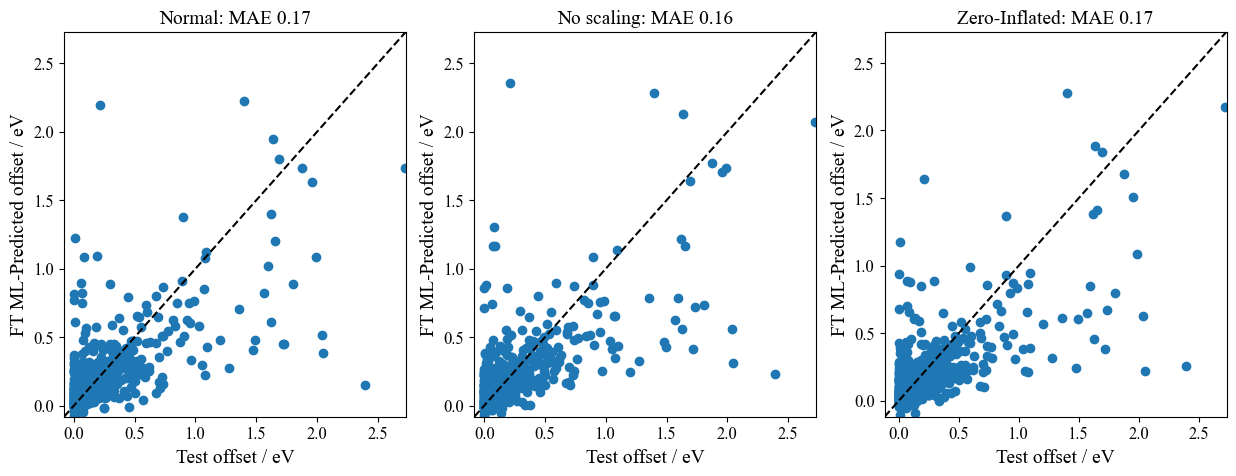

In [93]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_array_scatter(axs[0],'FT', 'Normal', ft_delta_array,0.01)
plot_array_scatter(axs[1],'FT', 'No scaling', ft_u_delta_array,0.01)
plot_array_scatter(axs[2],'FT', 'Zero-Inflated', ft_zi_delta_array,0.01)

Text(0.5, 0.98, 'Normal')

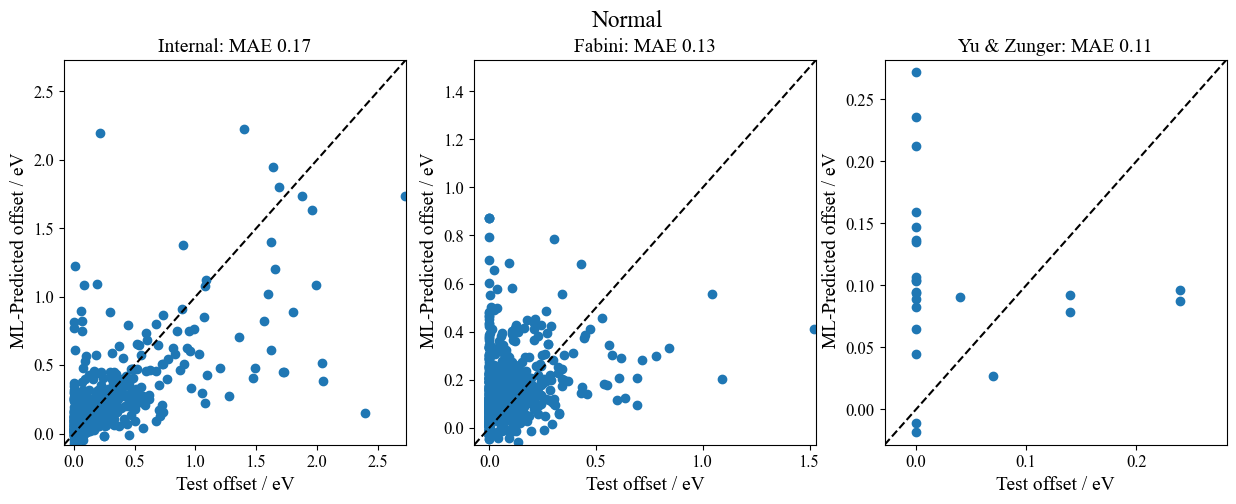

In [94]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_array_scatter(axs[0],'', 'Internal', ft_delta_array,0.01)
plot_array_scatter(axs[1],'', 'Fabini', fab_delta_array,0.01)
plot_array_scatter(axs[2],'', 'Yu & Zunger', yu_delta_array,0.01)
fig.suptitle('Normal')

Text(0.5, 0.98, 'No scaling')

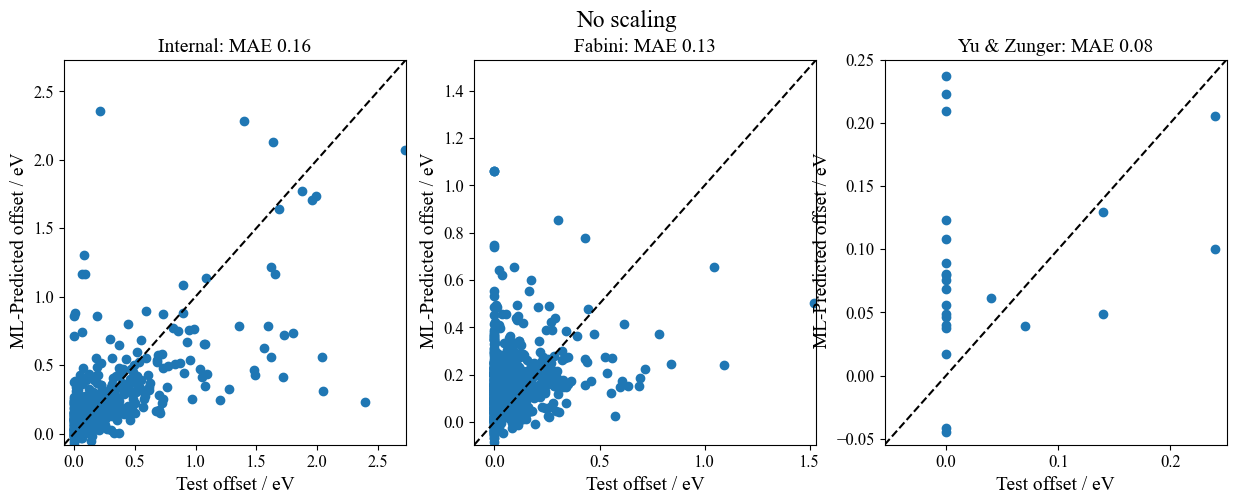

In [95]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_array_scatter(axs[0],'', 'Internal', ft_u_delta_array,0.01)
plot_array_scatter(axs[1],'', 'Fabini', fab_u_delta_array,0.01)
plot_array_scatter(axs[2],'', 'Yu & Zunger', yu_u_delta_array,0.01)
fig.suptitle('No scaling')

Text(0.5, 0.98, 'No scaling, zero-inflated')

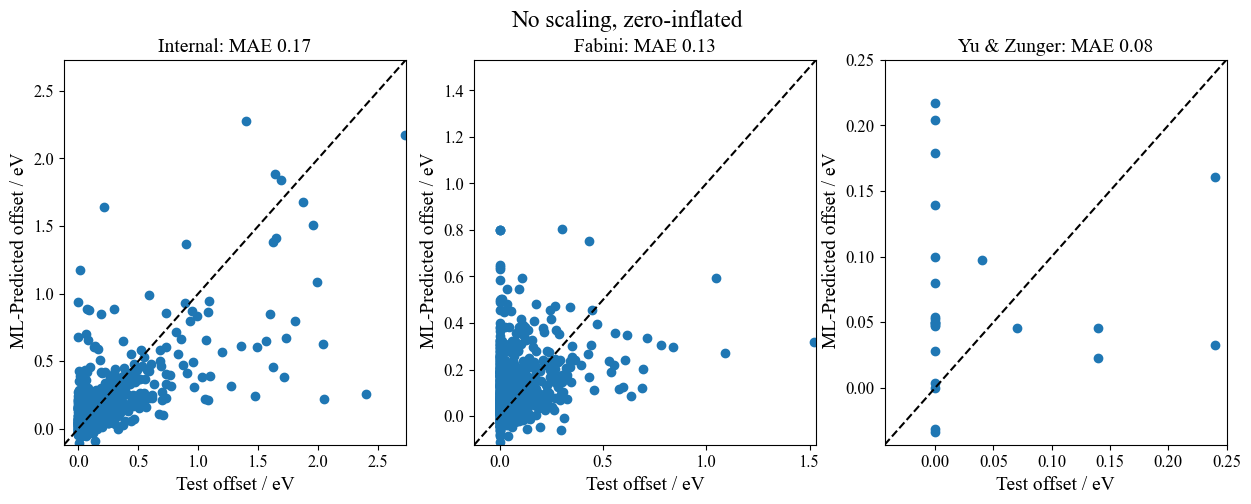

In [96]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_array_scatter(axs[0],'', 'Internal', ft_zi_delta_array,0.01)
plot_array_scatter(axs[1],'', 'Fabini', fab_zi_delta_array,0.01)
plot_array_scatter(axs[2],'', 'Yu & Zunger', yu_zi_delta_array,0.01)
fig.suptitle('No scaling, zero-inflated')

### Direct SLME prediction

In [97]:
eta_preds = csv_pred('FT_etas')
yu_eta_preds = csv_pred('FT_etas',yu=True)
yu_eta_preds = {str(k):v for k,v in yu_eta_preds.items()}


In [98]:
eta_array = get_pred_array(eta_preds,eta_acts)
fab_eta_array = get_pred_array(eta_preds,fab_etas)
yu_eta_array = get_pred_array(yu_eta_preds,yu_etas)

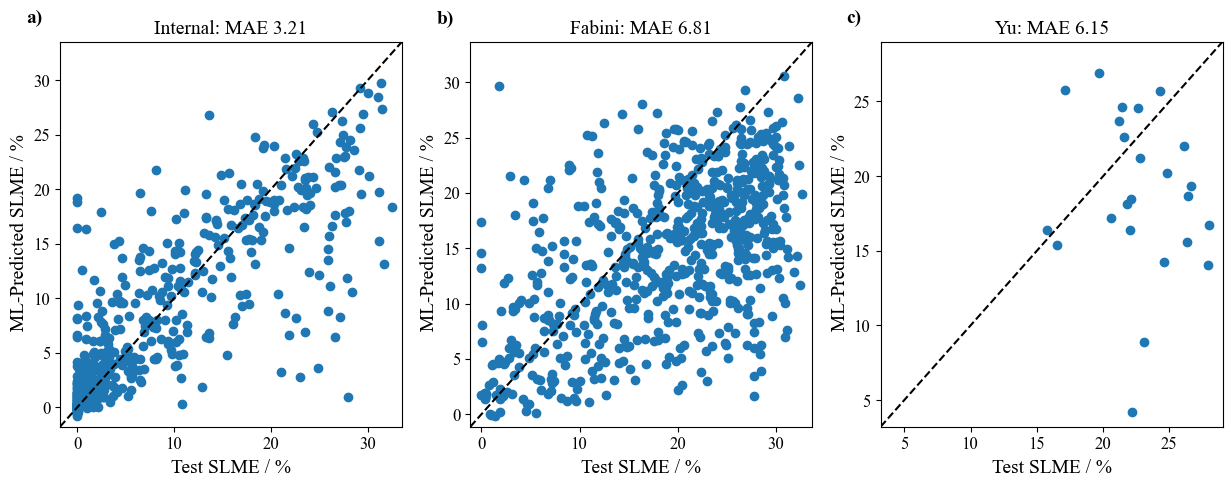

In [99]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_array_scatter(axs[0],'', 'Internal', eta_array,1,'SLME / %')
plot_array_scatter(axs[1],'', 'Fabini', fab_eta_array,1,'SLME / %')
plot_array_scatter(axs[2],'', 'Yu', yu_eta_array,1,'SLME / %')
axs[0].text(-0.1, 1.05, 'a)', transform=axs[0].transAxes, fontweight='bold')
axs[1].text(-0.1, 1.05, 'b)', transform=axs[1].transAxes, fontweight='bold')
axs[2].text(-0.1, 1.05, 'c)', transform=axs[2].transAxes, fontweight='bold')
fig.savefig('model_1_external.pdf', bbox_inches='tight')

### Band-gap

In [100]:
gap_preds = csv_pred('gaps')
yu_gap_preds = csv_pred('gaps',yu=True)
yu_gap_preds = {str(k):v for k,v in yu_gap_preds.items()}

In [101]:
gap_array = get_pred_array(gap_preds,gap_acts)
fab_gap_array = get_pred_array(gap_preds,fab_gaps)
yu_gap_array = get_pred_array(yu_gap_preds,yu_gaps)

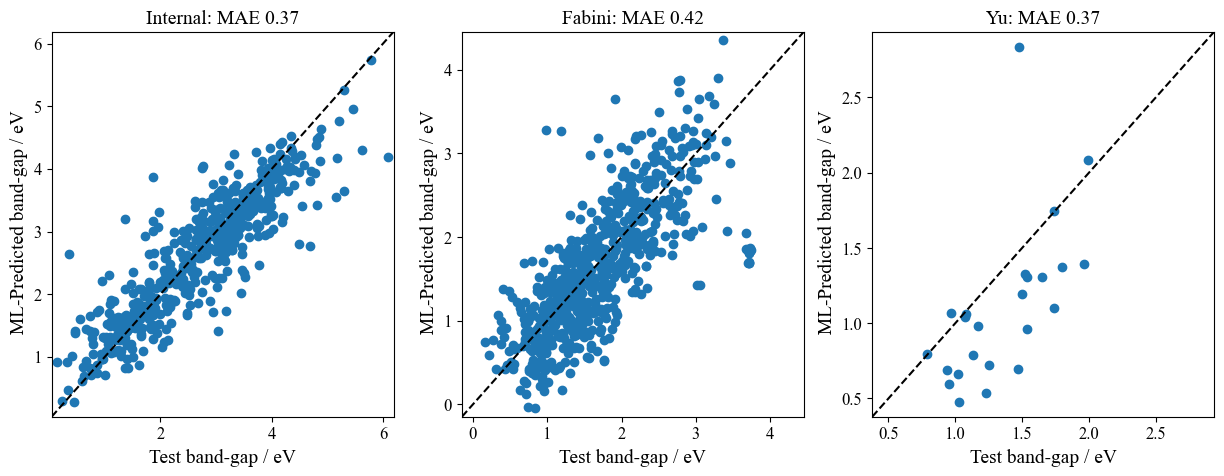

In [102]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_array_scatter(axs[0],'', 'Internal', gap_array,0.1,'band-gap / eV')
plot_array_scatter(axs[1],'', 'Fabini', fab_gap_array,0.1,'band-gap / eV')
plot_array_scatter(axs[2],'', 'Yu', yu_gap_array,0.1,'band-gap / eV')

## Summary of spectral methods

In [103]:
c_a_As_maes = {}
corr_alphas_As_maes = {}
c_As_maes = {}
corr_As_maes = {}
for id,true in corr_As_acts.items():
    pred_1 = c_a_As[id]
    pred_2 = corr_alphas_As[id]
    pred_3 = c_As[id]
    pred_4 = corr_As_preds[id]
    c_a_As_maes[id] = MAE(true,pred_1)
    corr_alphas_As_maes[id] = MAE(true,pred_2)
    c_As_maes[id] = MAE(true,pred_3)
    corr_As_maes[id] = MAE(true,pred_4)
    

In [104]:
np.mean(list(c_a_As_maes.values())), np.mean(list(corr_alphas_As_maes.values())), np.mean(list(c_As_maes.values())), np.mean(list(corr_As_maes.values()))

(0.10700472620991487,
 0.12888315848491677,
 0.07104189721879081,
 0.08452491816817953)

In [105]:
rows = []
xs = np.linspace(0,5,101)
for mpid in c_As:
    As_1 = c_a_As[mpid]
    As_2 = [0]+corr_alphas_As[mpid].tolist()
    As_3 = c_As[mpid]
    As_4 = [0]+corr_As_preds[mpid]
    eta1 = eff.calculate(xs,As_1,absorptance=True,del_E = ft_deltas[mpid])
    eta2 = eff.calculate(xs,As_2,absorptance=True,del_E = ft_deltas[mpid])
    eta3 = eff.calculate(xs,As_3,absorptance=True,del_E = ft_deltas[mpid])
    eta4 = eff.calculate(xs,As_4,absorptance=True,del_E = ft_deltas[mpid])
    rows.append([eta_acts[mpid],eta1,eta2,eta3,eta4])

In [106]:
abs_etas = np.array(rows)

In [107]:
rows = []
xs = np.linspace(0,5,101)
for mpid in c_As:
    As_1 = c_a_As[mpid]
    As_2 = [0]+corr_alphas_As[mpid].tolist()
    As_3 = c_As[mpid]
    As_4 = [0]+corr_As_preds[mpid]
    wm_0 = weighted_mean(xs,corr_As_acts[mpid])
    wm_1 = weighted_mean(xs,As_1)
    wm_2 = weighted_mean(xs,As_2)
    wm_3 = weighted_mean(xs,As_3)
    wm_4 = weighted_mean(xs,As_4)
    row = [wm_0,wm_1,wm_2,wm_3,wm_4]
    if np.any(np.isnan(row))==False:
        rows.append(row)
abs_wms = np.array(rows)

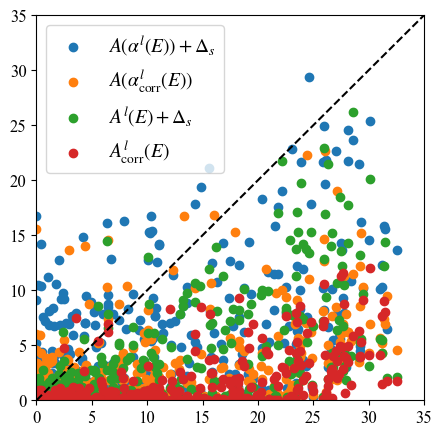

In [108]:
plt.figure(figsize = (5,5))
plt.xlim(0,35)
plt.ylim(0,35)
plt.scatter(abs_etas[:,0],abs_etas[:,1],label=r'$A(\alpha^l(E))+\Delta_s$')
plt.scatter(abs_etas[:,0],abs_etas[:,2],label=r'$A(\alpha_\text{corr}^l(E))$')
plt.scatter(abs_etas[:,0],abs_etas[:,3],label=r'$A^l(E)+\Delta_s$')
plt.scatter(abs_etas[:,0],abs_etas[:,4],label=r'$A^l_\text{corr}(E)$')
plt.plot([0,35],[0,35],'--k')
plt.legend()

In [109]:
titles = [r'$A(\alpha^l(E))+\Delta_s$',r'$A(\alpha_\text{corr}^l(E))$',r'$A^l(E)+\Delta_s$',r'$A^l_\text{corr}(E)$']

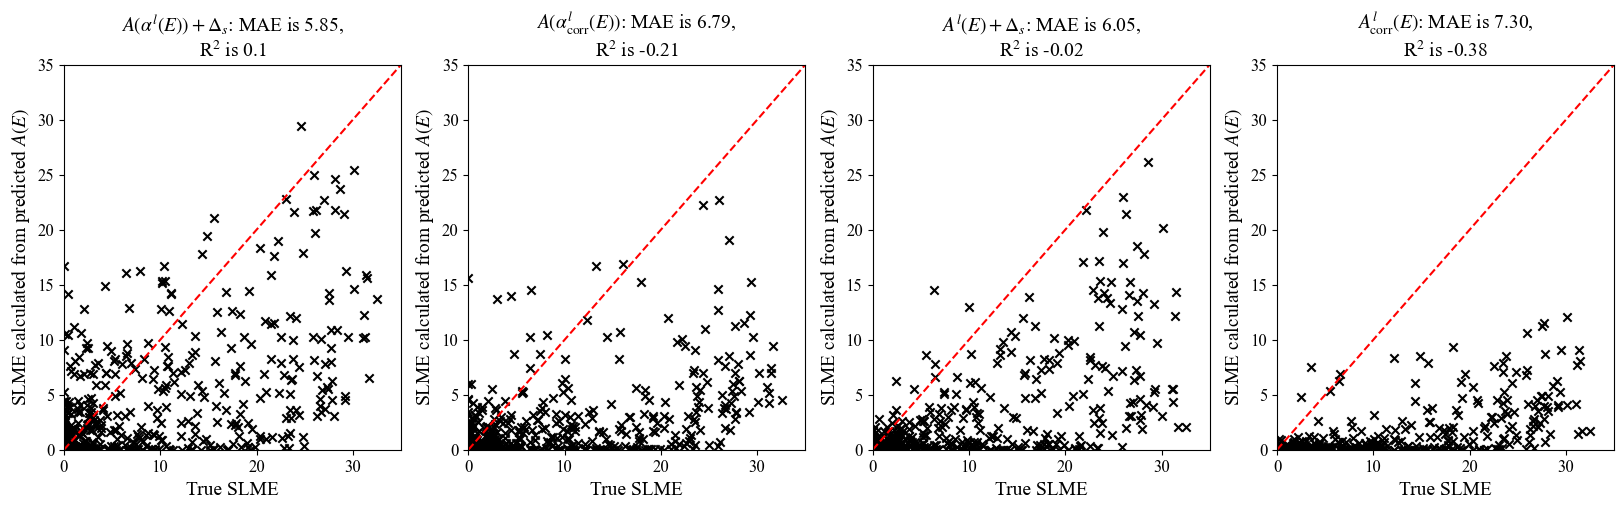

In [110]:
fig,axs = plt.subplots(1,4,figsize=(20,5))
for i in range(1,5):
    ax = axs[i-1]
    r2 = round(r2_score(abs_etas[:,0],abs_etas[:,i]),2)
    ax.set_ylim(0,35)
    ax.set_xlim(0,35)
    ax.scatter(abs_etas[:,0],abs_etas[:,i],marker='x',color='k')
    ax.plot([0,10,35],[0,10,35],'--r')
    #ax.text(2,1,r"$R^2$ is %s"%r2)
    ax.set_title(titles[i-1]+f": MAE is {MAE(abs_etas[:,0],abs_etas[:,i]):.2f}, \nR$^2$ is {r2}")
    ax.set_xlabel(r'True SLME')
    ax.set_ylabel(r'SLME calculated from predicted $A(E)$')
fig.savefig('ch4_abs_etas.pdf')

In [111]:
np.shape(abs_etas)

(538, 5)

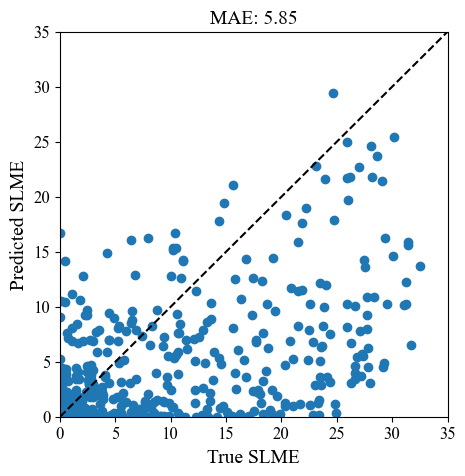

In [112]:
plt.figure(figsize=(5, 5))
plt.plot([0,35],[0,35], 'k--')
plt.scatter(abs_etas[:,0],abs_etas[:,1])
plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel('True SLME')
plt.ylabel('Predicted SLME')
plt.title('MAE: %.2f' % MAE(abs_etas[:,0],abs_etas[:,1]))
plt.savefig('alpha_eta_preds.pdf', bbox_inches='tight')

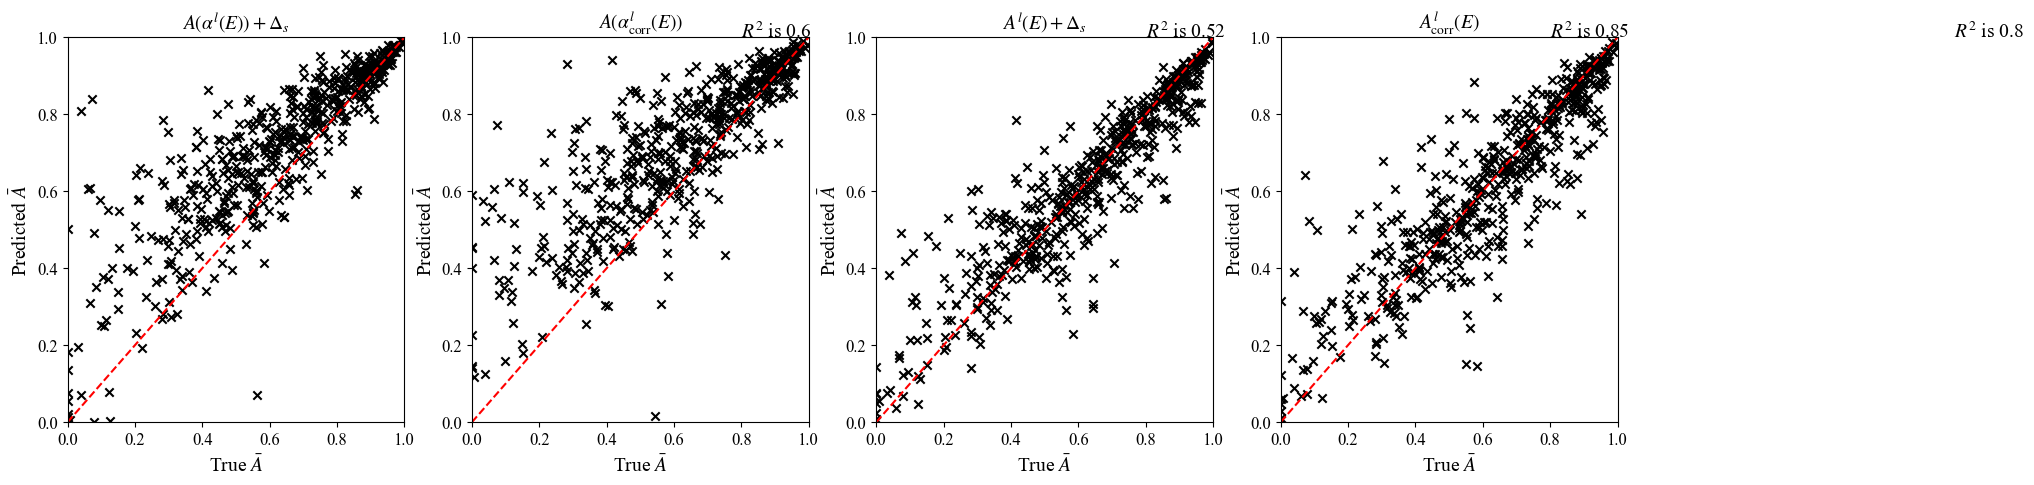

In [114]:
fig,axs = plt.subplots(1,4,figsize=(20,5))
for i in range(1,5):
    ax = axs[i-1]
    r2 = round(r2_score(abs_wms[:,0],abs_wms[:,i]),2)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.scatter(abs_wms[:,0],abs_wms[:,i],marker='x',color='k')
    ax.plot([0,1,5],[0,1,5],'--r')
    ax.text(2,1,r"$R^2$ is %s"%r2)
    ax.set_title(titles[i-1])
    ax.set_xlabel(r'True $\bar{A}$')
    ax.set_ylabel(r'Predicted $\bar{A}$')
fig.savefig('ch4_abs_wms.pdf')

In [ ]:
MAE(abs_etas[:,0],abs_etas[:,1]), MAE(abs_etas[:,0],abs_etas[:,2]), MAE(abs_etas[:,0],abs_etas[:,3]), MAE(abs_etas[:,0],abs_etas[:,4])
# alpha, corr alpha, absorptance, corr A


(5.852971150650132, 6.79359539665883, 6.051942987919036, 7.3006884045766345)

### Learned gap SQ

In [ ]:
def step(x,gap):
    if x<gap:
        return 0
    else:
        return 1

In [ ]:
sq_dict = {}
count=0
rows = []
xs = np.linspace(0,5,101)
for mpid,gap in gap_preds.items():
    if mpid in eta_acts:
        As = [step(x,gap) for x in xs]
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True)
        sq_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
sq_array = np.array(rows)


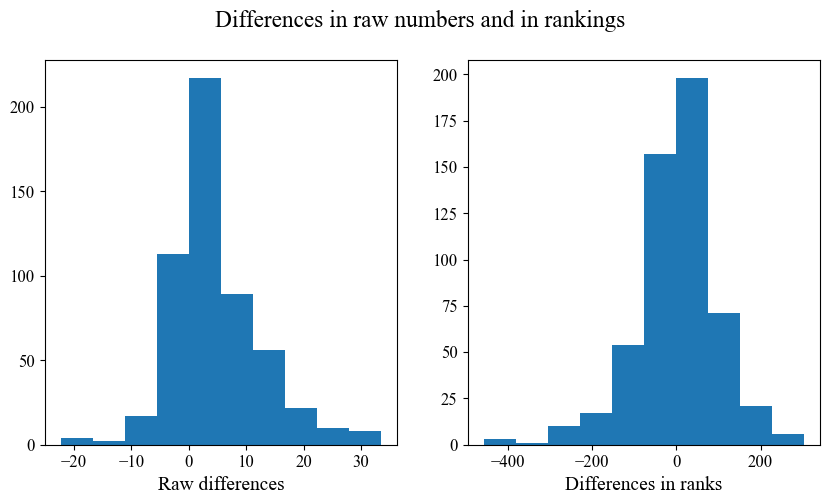

In [ ]:
sq_dd, sq_rd = rank(sq_array,sq_dict)

In [ ]:
MAE(sq_array[:,0],sq_array[:,1])

5.944799123258915

### Learn SLME directly

In [ ]:
eta_dict = {}
count=0
rows = []
for mpid,eta in eta_preds.items():
    if mpid in eta_acts:
        rows.append([eta,eta_acts[mpid]])
        eta_dict[mpid] = count
        count+=1
eta_array = np.array(rows)

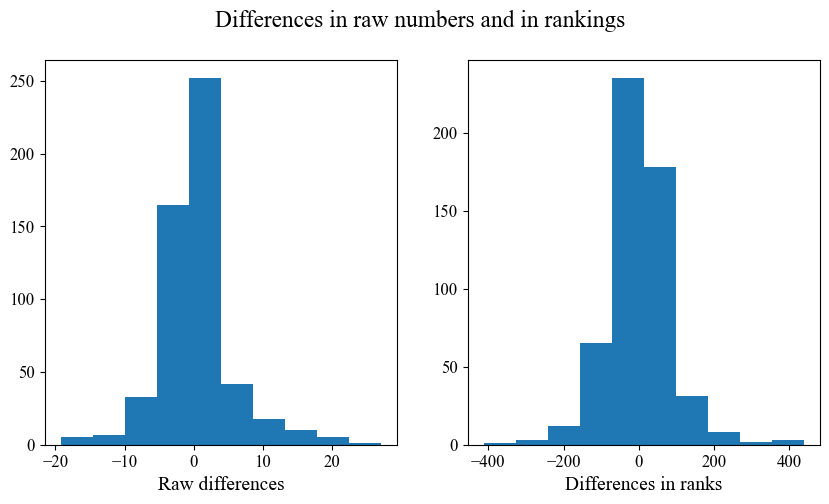

In [ ]:
eta_dd, eta_rd = rank(eta_array,eta_dict)

In [ ]:
MAE(eta_array[:,0],eta_array[:,1])

3.2101071816519053

### Learn Delta

In [ ]:
delta_dict = {}
count=0
rows = []
for mpid,delta in ft_delta_preds.items():
    if mpid in eta_acts:
        xs = np.linspace(0,5,101)
        As = corr_As_acts[mpid]
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True,del_E = delta)
        delta_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
delta_array = np.array(rows)

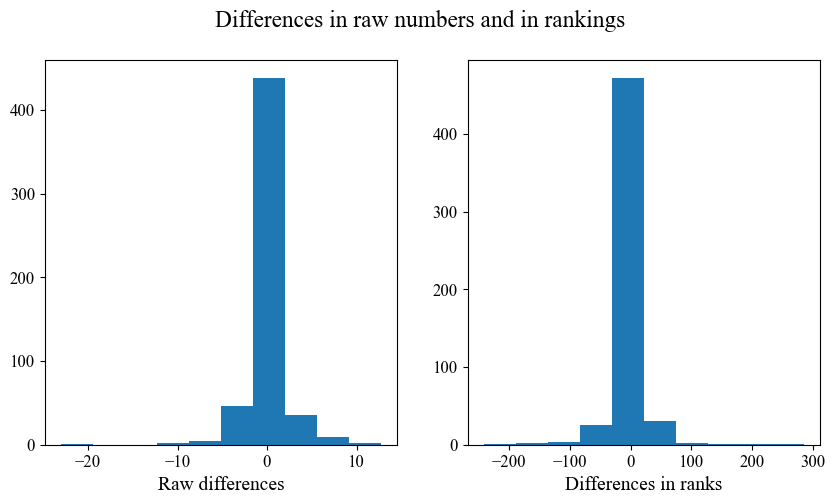

In [ ]:
delta_dd, delta_rd = rank(delta_array,delta_dict)

In [ ]:
MAE(delta_array[:,0],delta_array[:,1])

0.9615953008704037

#### Unscaled deltas

In [ ]:
u_delta_dict = {}
count=0
rows = []
for mpid,delta in ft_u_delta_preds.items():
    if mpid in eta_acts:
        xs = np.linspace(0,5,101)
        As = corr_As_acts[mpid]
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True,del_E = delta)
        u_delta_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
u_delta_array = np.array(rows)

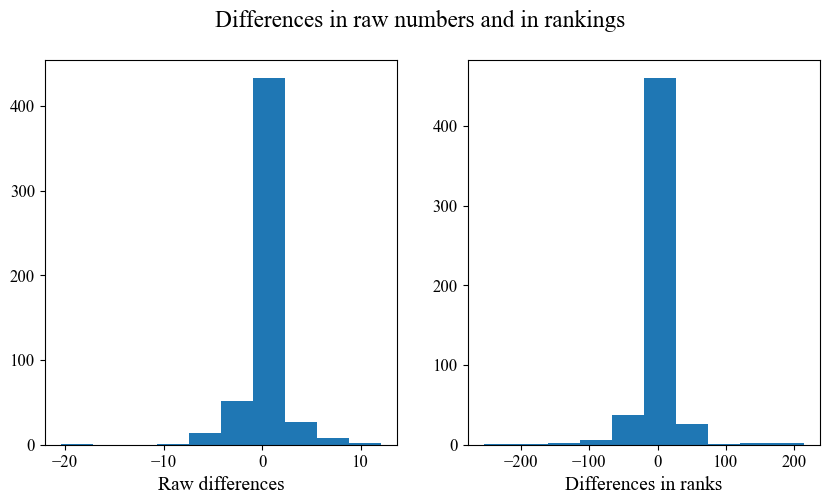

In [ ]:
u_delta_dd, u_delta_rd = rank(u_delta_array,u_delta_dict)

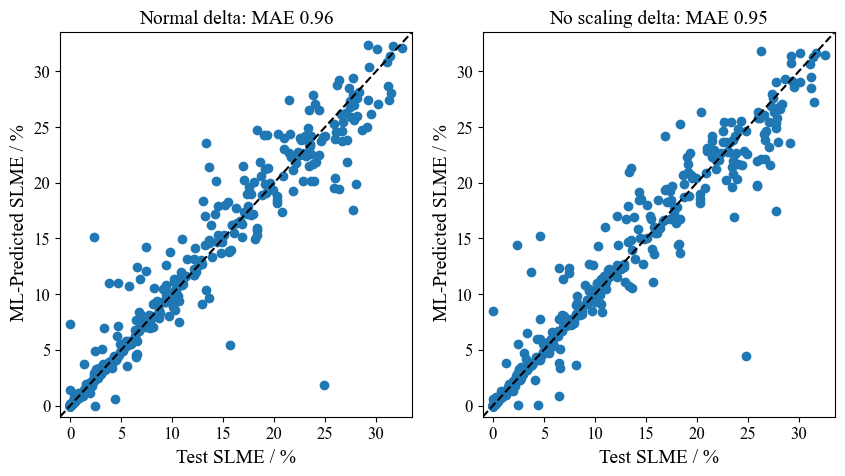

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
plot_array_scatter(axs[0],'', 'Normal delta', delta_array,1,'SLME / %')
plot_array_scatter(axs[1],'', 'No scaling delta', u_delta_array,1,'SLME / %')

### Learn correction

In [ ]:
corrs_dict = {}
count=0
rows = []
for mpid,corrs in corr_preds.items():
    if mpid in ft_deltas:
        xs = np.linspace(0,5,101)
        As = shifter(As_acts,corr_preds,mpid)
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True,del_E = ft_deltas[mpid])
        corrs_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
corrs_array = np.array(rows)

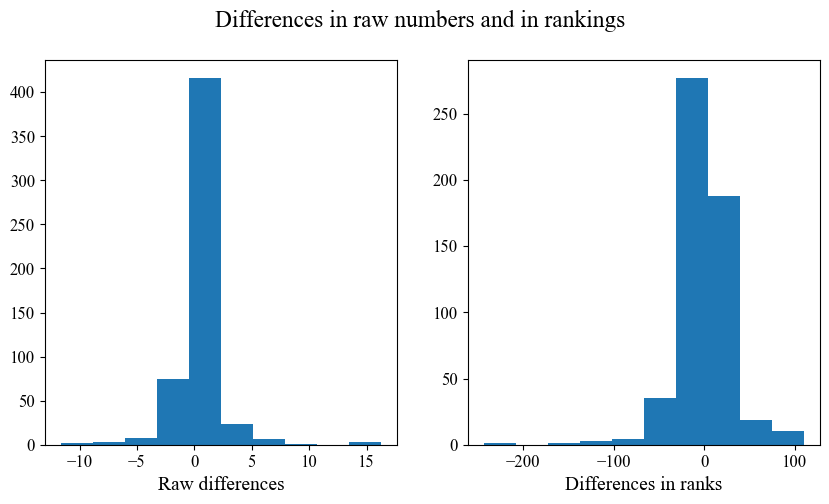

In [ ]:
corrs_dd, corrs_rd = rank(corrs_array,corrs_dict)

In [ ]:
MAE(corrs_array[:,0],corrs_array[:,1])

0.8988808541169238

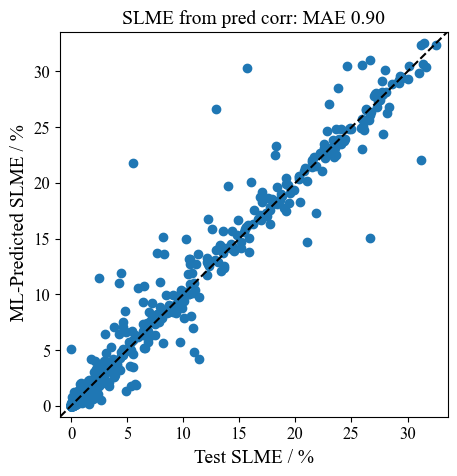

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
plot_array_scatter(axs,'', 'SLME from pred corr', corrs_array,1,'SLME / %')

### Learn spectrum

In [ ]:
corr_A_array = abs_etas[:,:3]

In [ ]:
corr_A_dict = {mpid:i for i, mpid in enumerate(c_As)}

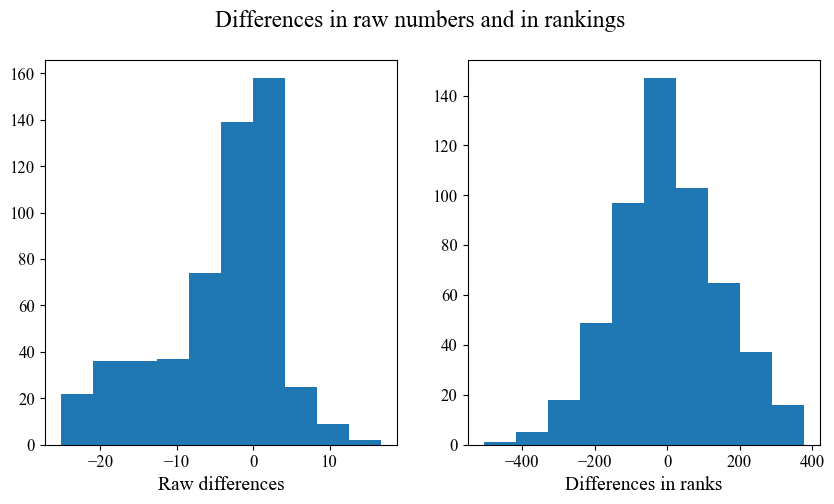

In [ ]:
corr_A_dd, corr_A_rd = rank(corr_A_array,corr_A_dict)

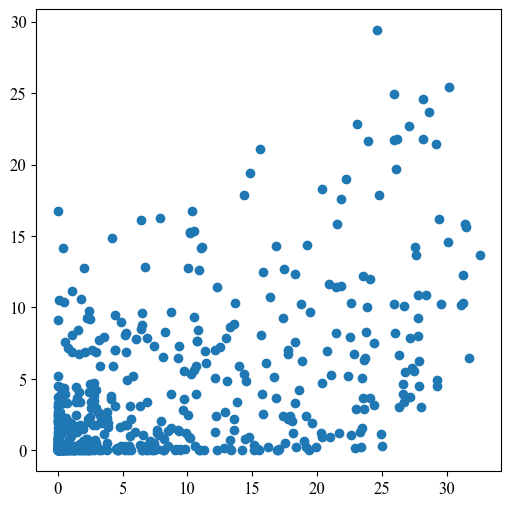

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(corr_A_array[:,0],corr_A_array[:,1])

### Learn corrected spectrum & offset

In [ ]:
all_dict = {}
count=0
rows = []
xs = np.linspace(0,5,101)
for mpid,delta in ft_delta_preds.items():
    if mpid in eta_acts:
        As = [0]+corr_As_preds[mpid]
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True,del_E = delta)
        all_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
all_array = np.array(rows)

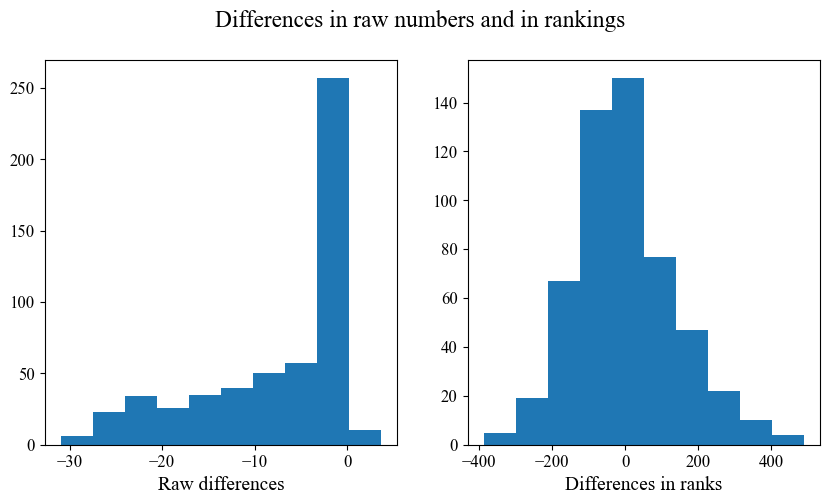

In [ ]:
all_dd, all_rd = rank(all_array,all_dict)

In [ ]:
MAE(all_array[:,0],all_array[:,1])

7.395113912816918

## Pareto front

### Error calcs for Pareto
For the remaining methods

In [ ]:
HSE_sq_dict = {}
count=0
rows = []
xs = np.linspace(0,5,101)
for mpid,gap in gap_acts.items():
    if mpid in eta_acts:
        As = [step(x,gap) for x in xs]
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True)
        HSE_sq_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
HSE_sq_array = np.array(rows)

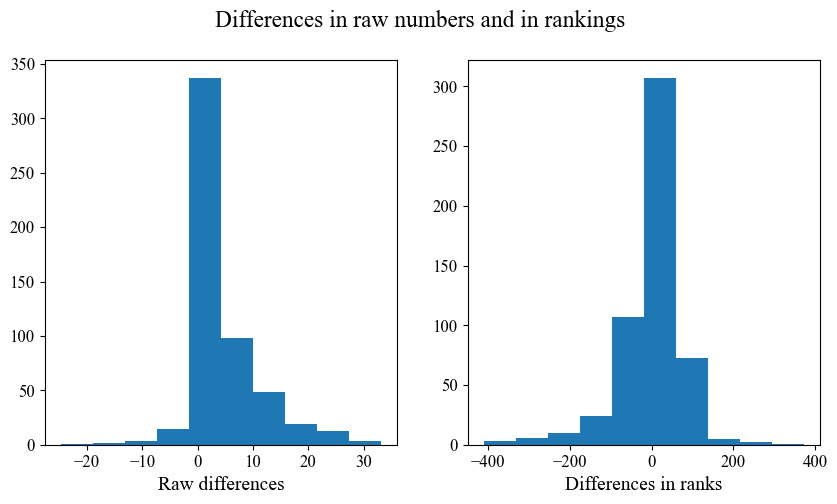

In [ ]:
HSE_sq_dd, HSE_sq_rd = rank(HSE_sq_array,HSE_sq_dict)

In [ ]:
all_kim_data = loadjson('/home/matthew/hybrid_gaps/MPID_Kim_data.json')

In [ ]:
gga_gaps = {k:v['GGA_gap'] for k,v in all_kim_data.items()}

In [ ]:
corr_GGA_sq_dict = {}
count=0
rows = []
xs = np.linspace(0,5,101)
for mpid,gap in gga_gaps.items():
    if mpid in eta_acts:
        gap += corr_preds[mpid]
        As = [step(x,gap) for x in xs]
        true_eta = eta_acts[mpid]
        eta = eff.calculate(xs,As,absorptance=True)
        corr_GGA_sq_dict[mpid] = count
        rows.append([true_eta,eta])
        count+=1
corr_GGA_sq_array = np.array(rows)

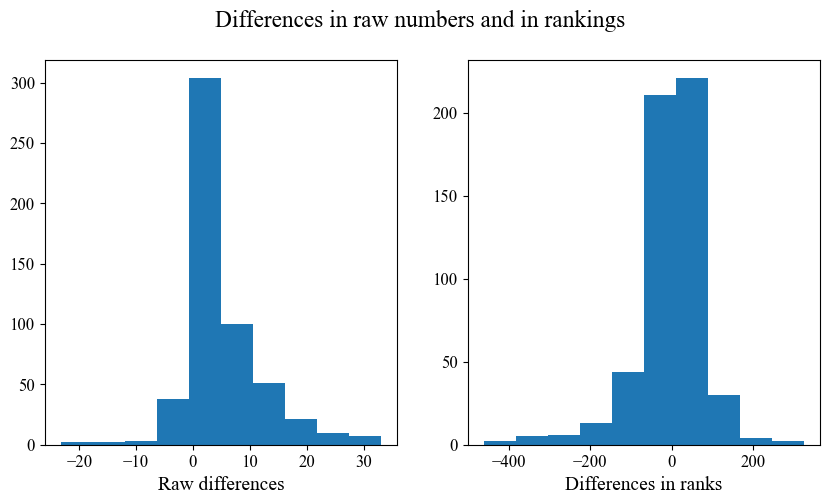

In [ ]:
corr_GGA_sq_dd, corr_GGA_sq_rd = rank(corr_GGA_sq_array,corr_GGA_sq_dict)

In [ ]:
all_GGA_dict = {}
count=0
rows = []
xs = np.linspace(0,5,101)
for mpid,As in As_acts.items():
    As = [0]+As
    delta = ft_deltas[mpid]
    true_eta = eta_acts[mpid]
    eta = eff.calculate(xs,As,absorptance=True,del_E = delta)
    all_GGA_dict[mpid] = count
    rows.append([true_eta,eta])
    count+=1
all_GGA_array = np.array(rows)

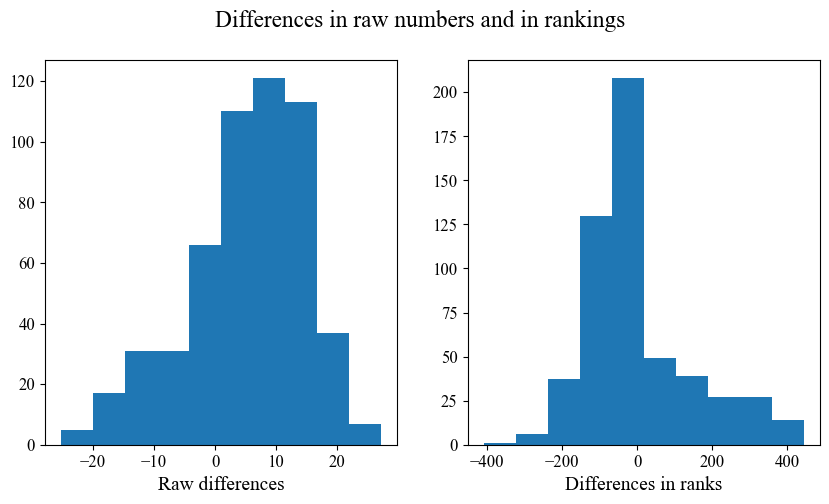

In [ ]:
all_GGA_dd, all_GGA_rd = rank(all_GGA_array,all_GGA_dict)

### Plot

In [ ]:
method_times = loadjson('../vasp_stuff/method_times.json')

In [ ]:
method_maes = {}

In [ ]:
method_maes['I'] = MAE(eta_array[:,0],eta_array[:,1])

In [ ]:
method_maes['II'] = MAE(all_array[:,0],all_array[:,1])

In [ ]:
method_maes['III'] = MAE(corrs_array[:,0],corrs_array[:,1])

In [ ]:
method_maes['IV'] = MAE(sq_array[:,0],sq_array[:,1])

In [ ]:
method_maes['V'] = MAE(HSE_sq_array[:,0],HSE_sq_array[:,1])

In [ ]:
method_maes['VI'] = MAE(corr_GGA_sq_array[:,0],corr_GGA_sq_array[:,1])

In [ ]:
method_maes['VII'] = MAE(all_GGA_array[:,0],all_GGA_array[:,1])

In [ ]:
method_maes['VIII'] = 0

In [ ]:
method_rank_MAEs = {}

In [ ]:
method_rank_MAEs['I'] = np.mean(np.abs(list(eta_rd.values())))

In [ ]:
method_rank_MAEs['II']= np.mean(np.abs(list(all_rd.values())))

In [ ]:
method_rank_MAEs['III']= np.mean(np.abs(list(corrs_rd.values())))

In [ ]:
method_rank_MAEs['IV'] = np.mean(np.abs(list(sq_rd.values())))

In [ ]:
method_rank_MAEs['V'] = np.mean(np.abs(list(HSE_sq_rd.values())))

In [ ]:
method_rank_MAEs['VI'] = np.mean(np.abs(list(corr_GGA_sq_rd.values())))

In [ ]:
method_rank_MAEs['VII'] = np.mean(np.abs(list(all_GGA_rd.values())))

In [ ]:
method_rank_MAEs['VIII'] = 0

/tmp/ipykernel_1349/4271407768.py:72: RankWarning: Polyfit may be poorly conditioned
  raw_pareto_y = np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times))


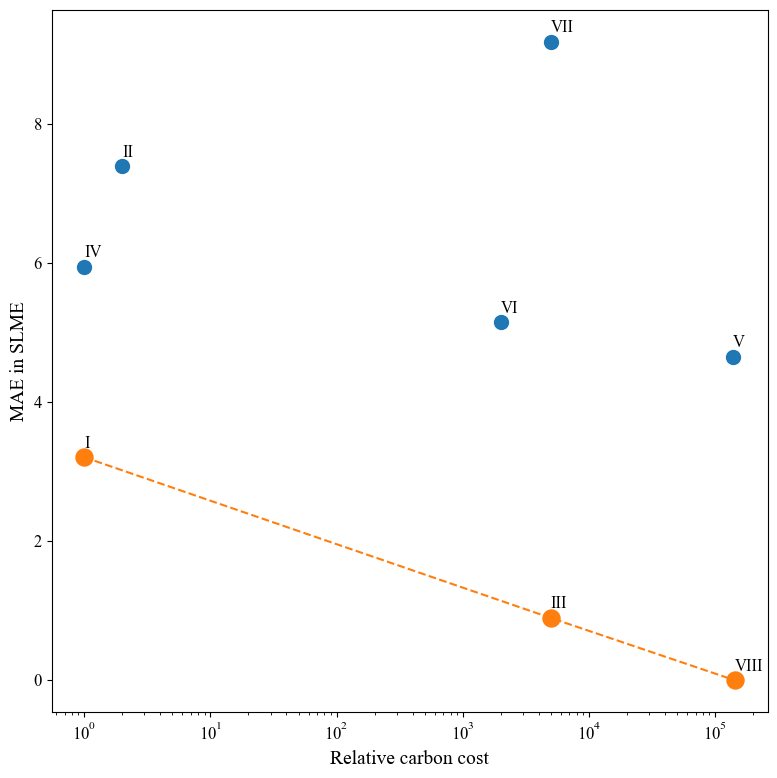

Pareto optimal methods:
Method I: Time = 0.018581, MAE = 3.2101071816519053
Method III: Time = 92.33658100000001, MAE = 0.8988808541169238
Method VIII: Time = 2675.8496923076914, MAE = 0


In [ ]:
mae_dict = method_maes
time_dict = method_times

# Extract the data points
methods = list(time_dict.keys())
raw_times = [time_dict[method] for method in methods]
times = (np.array(raw_times)/min(raw_times)).tolist()
maes = [mae_dict[method] for method in methods]

# Create a scatter plot
plt.figure(figsize=(8,8))
plt.scatter(times, maes, s=100, c='C0', alpha=1)

# Add labels to each point
for i, method in enumerate(methods):
    plt.annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(0,7), textcoords='offset points')

# Identify Pareto optimal points
# A point is Pareto optimal if no other point is better in both dimensions
pareto_optimal = []
pareto_indices = []

for i in range(len(methods)):
    is_pareto = True
    for j in range(len(methods)):
        if i != j:
            if times[j] <= times[i] and maes[j] <= maes[i] and (times[j] < times[i] or maes[j] < maes[i]):
                is_pareto = False
                break
    if is_pareto:
        pareto_optimal.append(methods[i])
        pareto_indices.append(i)

# Highlight Pareto optimal points
pareto_times = [times[i] for i in pareto_indices]
pareto_maes = [maes[i] for i in pareto_indices]
plt.scatter(pareto_times, pareto_maes, s=150, c='C1', alpha=1, label='Pareto Optimal')

# Sort pareto points for the curve fitting (by time)
sorted_indices = np.argsort(pareto_times)
sorted_pareto_times = [pareto_times[i] for i in sorted_indices]
sorted_pareto_maes = [pareto_maes[i] for i in sorted_indices]



# Add titles and labels
#plt.title('Pareto Front: Time Duration vs. MAE', fontsize=16)
plt.xlabel('Relative carbon cost', fontsize=14)
plt.ylabel('MAE in SLME', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Create a custom legend for all methods
handles = []
labels = []
for method in methods:
    color = 'C1' if method in pareto_optimal else 'C0'
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                        markersize=10, label=f'Method {method}')
    handles.append(handle)
    labels.append(f'Method {method}')

# Add the Pareto front line to legend if it exists
if len(pareto_optimal) >= 3:
    handle = plt.Line2D([0], [0], color='r', linestyle='--', label='Pareto Front')
    handles.append(handle)
    labels.append('Pareto Front')

#plt.plot(np.unique(sorted_pareto_times), np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times)),color='C1', linestyle='--')
raw_pareto_x = np.unique(sorted_pareto_times)
raw_pareto_y = np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times))
plt.plot(raw_pareto_x, raw_pareto_y, color='C1', linestyle='--')
#plt.legend(handles=handles, labels=labels, loc='best')
plt.xscale('log')

# Add grid
#plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('pareto_front.pdf',bbox_inches='tight')
plt.savefig('raw_pareto.svg',bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()


# Print out the Pareto optimal methods
print("Pareto optimal methods:")
for method in pareto_optimal:
    print(f"Method {method}: Time = {time_dict[method]}, MAE = {mae_dict[method]}")

In [ ]:
time_dict

{'I': 0.018581,
 'II': 0.037162,
 'III': 92.33658100000001,
 'IV': 0.018581,
 'V': 2583.5316923076916,
 'VI': 37.187965615384606,
 'VII': 92.31800000000001,
 'VIII': 2675.8496923076914}

In [ ]:
mae_dict

{'I': 3.2101071816519053,
 'II': 7.395113912816918,
 'III': 0.8988808541169238,
 'IV': 5.944799123258915,
 'V': 4.655746280224506,
 'VI': 5.150083546329989,
 'VII': 9.184505670335682,
 'VIII': 0}

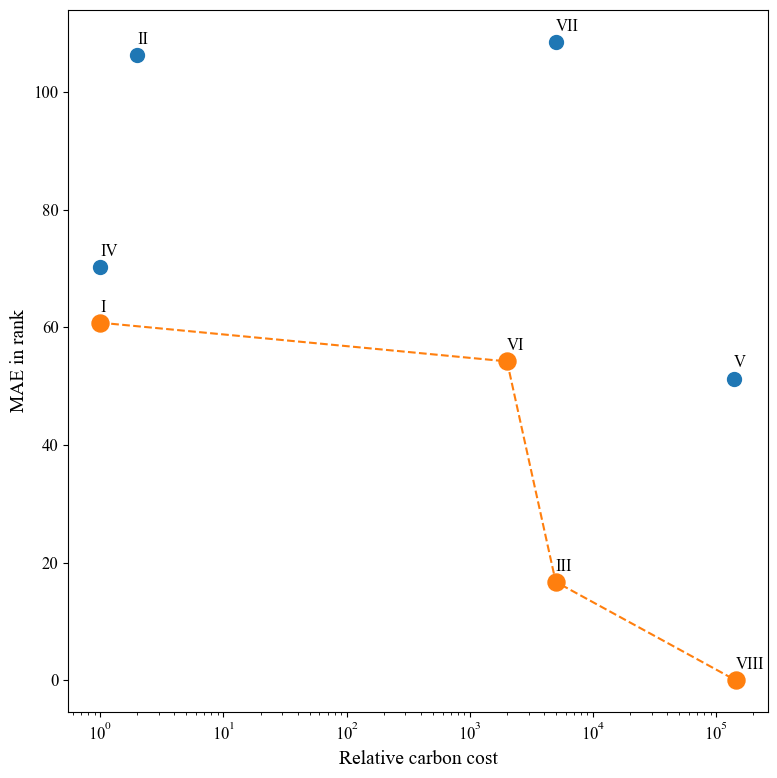

Pareto optimal methods:
Method I: Time = 0.018581, MAE = 60.806691449814124
Method III: Time = 92.33658100000001, MAE = 16.7546468401487
Method VI: Time = 37.187965615384606, MAE = 54.23048327137546
Method VIII: Time = 2675.8496923076914, MAE = 0


In [ ]:
mae_dict = method_rank_MAEs
time_dict = method_times

# Extract the data points
methods = list(time_dict.keys())
raw_times = [time_dict[method] for method in methods]
times = (np.array(raw_times)/min(raw_times)).tolist()
maes = [mae_dict[method] for method in methods]
rank_maes = maes
# Create a scatter plot
plt.figure(figsize=(8,8))
plt.scatter(times, rank_maes, s=100, c='C0', alpha=1)

# Add labels to each point
for i, method in enumerate(methods):
    plt.annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(0,8), textcoords='offset points')

# Identify Pareto optimal points
# A point is Pareto optimal if no other point is better in both dimensions
pareto_optimal = []
pareto_indices = []

for i in range(len(methods)):
    is_pareto = True
    for j in range(len(methods)):
        if i != j:
            if times[j] <= times[i] and maes[j] <= maes[i] and (times[j] < times[i] or maes[j] < maes[i]):
                is_pareto = False
                break
    if is_pareto:
        pareto_optimal.append(methods[i])
        pareto_indices.append(i)

# Highlight Pareto optimal points
pareto_times = [times[i] for i in pareto_indices]
pareto_maes = [maes[i] for i in pareto_indices]
rank_pareto_times = pareto_times
rank_pareto_maes = pareto_maes
plt.scatter(rank_pareto_times, rank_pareto_maes, s=150, c='C1', alpha=1, label='Pareto Optimal')


# Sort pareto points for the curve fitting (by time)
sorted_indices = np.argsort(pareto_times)
sorted_pareto_times = [pareto_times[i] for i in sorted_indices]
sorted_pareto_maes = [pareto_maes[i] for i in sorted_indices]



# Add titles and labels
#plt.title('Pareto Front: Time Duration vs. MAE', fontsize=16)
plt.xlabel('Relative carbon cost', fontsize=14)
plt.ylabel('MAE in rank', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Create a custom legend for all methods
handles = []
labels = []
for method in methods:
    color = 'C1' if method in pareto_optimal else 'C0'
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                        markersize=10, label=f'Method {method}')
    handles.append(handle)
    labels.append(f'Method {method}')

# Add the Pareto front line to legend if it exists
if len(pareto_optimal) >= 3:
    handle = plt.Line2D([0], [0], color='r', linestyle='--', label='Pareto Front')
    handles.append(handle)
    labels.append('Pareto Front')

#plt.plot(np.unique(sorted_pareto_times), np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times)),color='C1', linestyle='--')
rank_pareto_x = np.unique(sorted_pareto_times)
rank_pareto_y = np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times))
plt.plot(rank_pareto_x,rank_pareto_y,color='C1', linestyle='--')
#plt.legend(handles=handles, labels=labels, loc='best')
plt.xscale('log')

# Add grid
#plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('rank_pareto_front.pdf',bbox_inches='tight')
plt.savefig('rank_pareto.svg',bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()


# Print out the Pareto optimal methods
print("Pareto optimal methods:")
for method in pareto_optimal:
    print(f"Method {method}: Time = {time_dict[method]}, MAE = {mae_dict[method]}")

/tmp/ipykernel_1349/2397128177.py:77: RankWarning: Polyfit may be poorly conditioned
  raw_pareto_y = np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times))


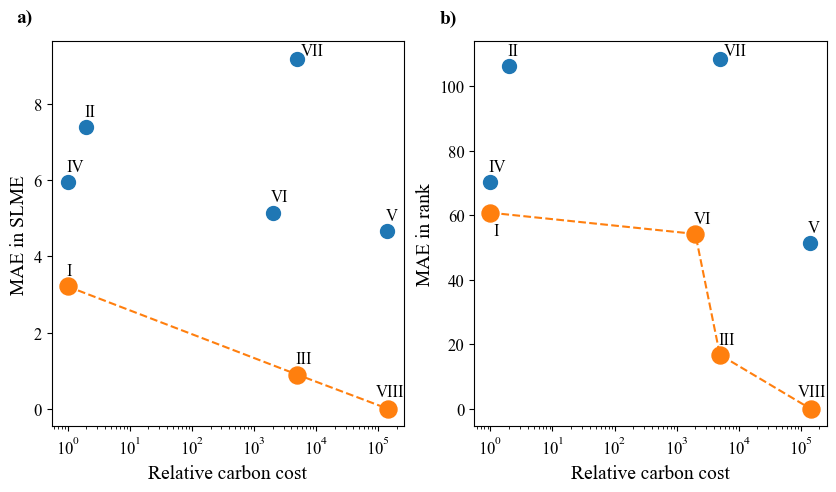

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
mae_dict = method_maes
time_dict = method_times

# Extract the data points
methods = list(time_dict.keys())
raw_times = [time_dict[method] for method in methods]
times = (np.array(raw_times)/min(raw_times)).tolist()
maes = [mae_dict[method] for method in methods]

# Create a scatter plot
axs[0].scatter(times, maes, s=100, c='C0', alpha=1)

# Add labels to each point
for i, method in enumerate(methods):
    if method == 'VII':
        axs[0].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(3,3), textcoords='offset points')
    elif method == 'VIII':
        axs[0].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(-9,9), textcoords='offset points')
    else:
        axs[0].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(-1,8), textcoords='offset points')
# Identify Pareto optimal points
# A point is Pareto optimal if no other point is better in both dimensions
pareto_optimal = []
pareto_indices = []

for i in range(len(methods)):
    is_pareto = True
    for j in range(len(methods)):
        if i != j:
            if times[j] <= times[i] and maes[j] <= maes[i] and (times[j] < times[i] or maes[j] < maes[i]):
                is_pareto = False
                break
    if is_pareto:
        pareto_optimal.append(methods[i])
        pareto_indices.append(i)

# Highlight Pareto optimal points
pareto_times = [times[i] for i in pareto_indices]
pareto_maes = [maes[i] for i in pareto_indices]
axs[0].scatter(pareto_times, pareto_maes, s=150, c='C1', alpha=1, label='Pareto Optimal')

# Sort pareto points for the curve fitting (by time)
sorted_indices = np.argsort(pareto_times)
sorted_pareto_times = [pareto_times[i] for i in sorted_indices]
sorted_pareto_maes = [pareto_maes[i] for i in sorted_indices]



# Add titles and labels
#plt.title('Pareto Front: Time Duration vs. MAE', fontsize=16)
axs[0].set_xlabel('Relative carbon cost')
axs[0].set_ylabel('MAE in SLME')


# Create a custom legend for all methods
handles = []
labels = []
for method in methods:
    color = 'C1' if method in pareto_optimal else 'C0'
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                        markersize=10, label=f'Method {method}')
    handles.append(handle)
    labels.append(f'Method {method}')

# Add the Pareto front line to legend if it exists
if len(pareto_optimal) >= 3:
    handle = plt.Line2D([0], [0], color='r', linestyle='--', label='Pareto Front')
    handles.append(handle)
    labels.append('Pareto Front')

#plt.plot(np.unique(sorted_pareto_times), np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times)),color='C1', linestyle='--')
raw_pareto_x = np.unique(sorted_pareto_times)
raw_pareto_y = np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times))
axs[0].plot(raw_pareto_x, raw_pareto_y, color='C1', linestyle='--')
#plt.legend(handles=handles, labels=labels, loc='best')
axs[0].set_xscale('log')
axs[0].text(-0.1, 1.05, 'a)', transform=axs[0].transAxes, fontweight='bold')
mae_dict = method_rank_MAEs
time_dict = method_times

# Extract the data points
methods = list(time_dict.keys())
raw_times = [time_dict[method] for method in methods]
times = (np.array(raw_times)/min(raw_times)).tolist()
maes = [mae_dict[method] for method in methods]
rank_maes = maes

axs[1].scatter(times, rank_maes, s=100, c='C0', alpha=1)

# Add labels to each point
for i, method in enumerate(methods):
    if method == "I":
       axs[1].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(2,-16), textcoords='offset points') 
    elif method == 'VII':
        axs[1].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(3,3), textcoords='offset points')
    elif method == 'VIII':
        axs[1].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(-9,9), textcoords='offset points')
    else:
        axs[1].annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(-1,8), textcoords='offset points')

# Identify Pareto optimal points
# A point is Pareto optimal if no other point is better in both dimensions
pareto_optimal = []
pareto_indices = []

for i in range(len(methods)):
    is_pareto = True
    for j in range(len(methods)):
        if i != j:
            if times[j] <= times[i] and maes[j] <= maes[i] and (times[j] < times[i] or maes[j] < maes[i]):
                is_pareto = False
                break
    if is_pareto:
        pareto_optimal.append(methods[i])
        pareto_indices.append(i)

# Highlight Pareto optimal points
pareto_times = [times[i] for i in pareto_indices]
pareto_maes = [maes[i] for i in pareto_indices]
rank_pareto_times = pareto_times
rank_pareto_maes = pareto_maes
axs[1].scatter(rank_pareto_times, rank_pareto_maes, s=150, c='C1', alpha=1, label='Pareto Optimal')


# Sort pareto points for the curve fitting (by time)
sorted_indices = np.argsort(pareto_times)
sorted_pareto_times = [pareto_times[i] for i in sorted_indices]
sorted_pareto_maes = [pareto_maes[i] for i in sorted_indices]



# Add titles and labels
#plt.title('Pareto Front: Time Duration vs. MAE', fontsize=16)
axs[1].set_xlabel('Relative carbon cost')
axs[1].set_ylabel('MAE in rank')

# Create a custom legend for all methods
handles = []
labels = []
for method in methods:
    color = 'C1' if method in pareto_optimal else 'C0'
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                        markersize=10, label=f'Method {method}')
    handles.append(handle)
    labels.append(f'Method {method}')

# Add the Pareto front line to legend if it exists
if len(pareto_optimal) >= 3:
    handle = plt.Line2D([0], [0], color='r', linestyle='--', label='Pareto Front')
    handles.append(handle)
    labels.append('Pareto Front')

#plt.plot(np.unique(sorted_pareto_times), np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times)),color='C1', linestyle='--')
rank_pareto_x = np.unique(sorted_pareto_times)
rank_pareto_y = np.poly1d(np.polyfit(sorted_pareto_times, sorted_pareto_maes, 3))(np.unique(sorted_pareto_times))
axs[1].plot(rank_pareto_x,rank_pareto_y,color='C1', linestyle='--')
#plt.legend(handles=handles, labels=labels, loc='best')
axs[1].set_xscale('log')
axs[1].text(-0.1, 1.05, 'b)', transform=axs[1].transAxes, fontweight='bold')
fig.savefig('pareto_fronts.pdf',bbox_inches='tight')


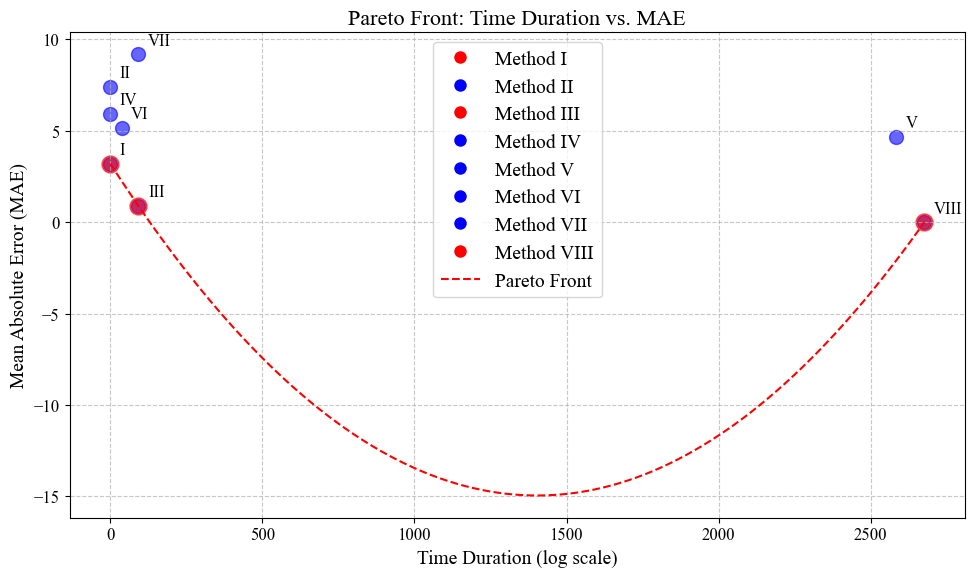

Pareto optimal methods:
Method I: Time = 0.018581, MAE = 3.2101071816519053
Method III: Time = 92.33658100000001, MAE = 0.8988808541169238
Method VIII: Time = 2675.8496923076914, MAE = 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Actual data provided
time_dict = {
    'I': 0.018581,
    'II': 0.037162,
    'III': 92.33658100000001,
    'IV': 0.018581,
    'V': 2583.5316923076916,
    'VI': 37.187965615384606,
    'VII': 92.31800000000001,
    'VIII': 2675.8496923076914
}

mae_dict = {
    'I': 3.2101071816519053,
    'II': 7.395113912816918,
    'III': 0.8988808541169238,
    'IV': 5.944799123258915,
    'V': 4.655746280224506,
    'VI': 5.150083546329989,
    'VII': 9.184505670335682,
    'VIII': 0
}

# Extract the data points
methods = list(time_dict.keys())
times = [time_dict[method] for method in methods]
maes = [mae_dict[method] for method in methods]

# Create a scatter plot with logarithmic scale for time (due to large range)
plt.figure(figsize=(10, 6))
#plt.xscale('log')  # Use log scale for x-axis due to large range in time values
plt.scatter(times, maes, s=100, c='blue', alpha=0.6)

# Add labels to each point
for i, method in enumerate(methods):
    plt.annotate(method, (times[i], maes[i]), fontsize=12, 
                 xytext=(7, 7), textcoords='offset points')

# Identify Pareto optimal points
# A point is Pareto optimal if no other point is better in both dimensions
pareto_optimal = []
pareto_indices = []

for i in range(len(methods)):
    is_pareto = True
    for j in range(len(methods)):
        if i != j:
            if times[j] <= times[i] and maes[j] <= maes[i] and (times[j] < times[i] or maes[j] < maes[i]):
                is_pareto = False
                break
    if is_pareto:
        pareto_optimal.append(methods[i])
        pareto_indices.append(i)

# Highlight Pareto optimal points
pareto_times = [times[i] for i in pareto_indices]
pareto_maes = [maes[i] for i in pareto_indices]
plt.scatter(pareto_times, pareto_maes, s=150, c='red', alpha=0.6, label='Pareto Optimal')

# Sort pareto points for the curve fitting (by time)
sorted_indices = np.argsort(pareto_times)
sorted_pareto_times = [pareto_times[i] for i in sorted_indices]
sorted_pareto_maes = [pareto_maes[i] for i in sorted_indices]

# Add a curve of best fit through Pareto optimal points
# Handle the curve fitting more carefully due to potential issues with limited points
if len(pareto_optimal) >= 3:
    try:
        # Try using spline interpolation with appropriate smoothing
        k = min(len(pareto_optimal)-1, 3)  # k must be less than number of points
        tck = interpolate.splrep(sorted_pareto_times, sorted_pareto_maes, k=k, s=0)
        x_new = np.linspace(min(sorted_pareto_times), max(sorted_pareto_times), 100)
        y_new = interpolate.splev(x_new, tck, der=0)
        plt.plot(x_new, y_new, 'r--', label='Pareto Front')
    except Exception as e:
        print(f"Could not create spline curve: {e}")
        # Fall back to a simple line connecting the points
        plt.plot(sorted_pareto_times, sorted_pareto_maes, 'r--', label='Pareto Front')
elif len(pareto_optimal) == 2:
    # Simple line for just 2 points
    plt.plot(sorted_pareto_times, sorted_pareto_maes, 'r--', label='Pareto Front')

# Add titles and labels
plt.title('Pareto Front: Time Duration vs. MAE', fontsize=16)
plt.xlabel('Time Duration (log scale)', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)

# Create a custom legend for all methods
handles = []
labels = []
for method in methods:
    color = 'red' if method in pareto_optimal else 'blue'
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                        markersize=10, label=f'Method {method}')
    handles.append(handle)
    labels.append(f'Method {method}')

# Add the Pareto front line to legend if it exists
if len(pareto_optimal) >= 3:
    handle = plt.Line2D([0], [0], color='r', linestyle='--', label='Pareto Front')
    handles.append(handle)
    labels.append('Pareto Front')

plt.legend(handles=handles, labels=labels, loc='best')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Print out the Pareto optimal methods
print("Pareto optimal methods:")
for method in pareto_optimal:
    print(f"Method {method}: Time = {time_dict[method]}, MAE = {mae_dict[method]}")

# Violin Plots

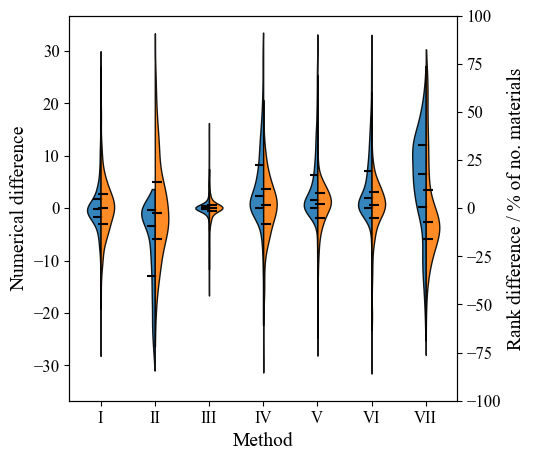

In [ ]:
Ia = list(eta_dd.values())
Ib = 100*np.array(list(eta_rd.values()))/len(eta_rd)
IIa = list(all_dd.values())
IIb = 100*np.array(list(all_rd.values()))/len(all_rd)
IIIa = list(corrs_dd.values())
IIIb = 100*np.array(list(corrs_rd.values()))/len(corrs_rd)
IVa = list(sq_dd.values())
IVb = 100*np.array(list(sq_rd.values()))/len(sq_rd)
Va = list(HSE_sq_dd.values())
Vb = 100*np.array(list(HSE_sq_rd.values()))/len(HSE_sq_rd)
VIa = list(corr_GGA_sq_dd.values())
VIb = 100*np.array(list(corr_GGA_sq_rd.values()))/len(corr_GGA_sq_rd)
VIIa = list(all_GGA_dd.values())
VIIb = 100*np.array(list(all_GGA_rd.values()))/len(all_GGA_rd)

s_kwargs = {"s": 50, "marker": "_"}
v_kwargs = {"showextrema": False, "showmedians": False, "showmeans": False, "widths": 0.5}

# create the figure and the axes (left and right)
fig, ax1 = plt.subplots(figsize=(5,5))
ax2 = ax1.twinx()

blue = 'C0'
orange = 'C1'

#LHS of violin plots (axis 1)
ax1.set_ylabel('Numerical difference', color='k')
ax1.tick_params(axis='y', labelcolor='k')
custom_violin(ax1, Ia, 0.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, IIa, 1.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, IIIa, 2.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, IVa, 3.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, Va, 4.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, VIa, 5.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, VIIa, 6.25, blue, 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)

# RHS of violin plots (axis 2)
ax2.set_ylabel('Rank difference / % of no. materials', color='k')
ax2.tick_params(axis='y', labelcolor='k')
custom_violin(ax2, Ib, 0.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, IIb, 1.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, IIIb, 2.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, IVb, 3.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, Vb, 4.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, VIb, 5.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, VIIb, 6.25, orange, 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)

# set the x-axis tick locations and labels
ax1.set_xticks([0.25, 1.25,2.25,3.25,4.25,5.25,6.25])
ax1.set_xticklabels(['I', 'II','III','IV','V','VI','VII'])
ax2.set_ylim(-100,100)
ax1.set_xlabel('Method')
#ax1.set_title('Different methods for estimating SLME compared to Fabini data')

# adjust the position of the axes
org1 = 0.0  # Origin of first axis
org2 = 0.0  # Origin of second axis
pos = 0.5  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)

#ax1.axvline(x=0.25,color='r',linestyle='--') idea to show vertical lines to indicate e.g. the peak height of half the population to give a sense of relative heights of peaks
#plt.title('SQ, SLME, corr. A, correction, delta, corr A & delta')
plt.savefig('methods_violin_plot.pdf',bbox_inches='tight')
plt.savefig('methods_violin_plot.svg',bbox_inches='tight')

(array([  6.,  23.,  34.,  26.,  35.,  40.,  50.,  57., 257.,  10.]),
 array([-30.95333042, -27.49141116, -24.0294919 , -20.56757264,
        -17.10565338, -13.64373412, -10.18181486,  -6.7198956 ,
         -3.25797634,   0.20394292,   3.66586218]),
 <BarContainer object of 10 artists>)

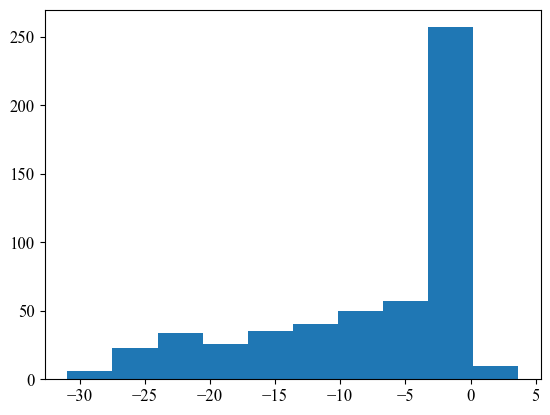

In [ ]:
plt.hist(IIa)

## Comparing functionals

In [ ]:
mbj_comp = loadjson('/home/matthew/mpcontribs-downloads/TBmBJ_vs_fab.json')

In [ ]:
choud_diffs = mbj_comp['raw']
choud_ranks = mbj_comp['rank']

In [ ]:
fab_eta_dict = {}
count = 0
for id in eta_preds:
    if id in fab_etas:
        fab_eta_dict[id] = count
        count+=1

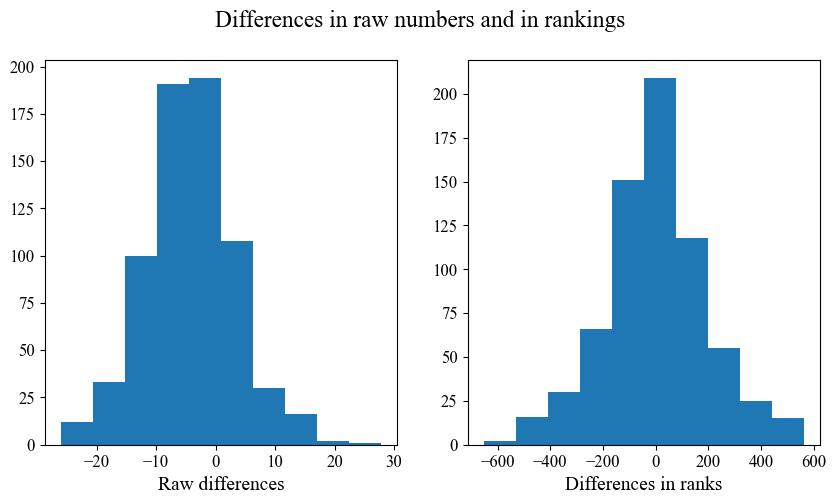

In [ ]:
fab_eta_dd, fab_eta_rd = rank(fab_eta_array,fab_eta_dict)

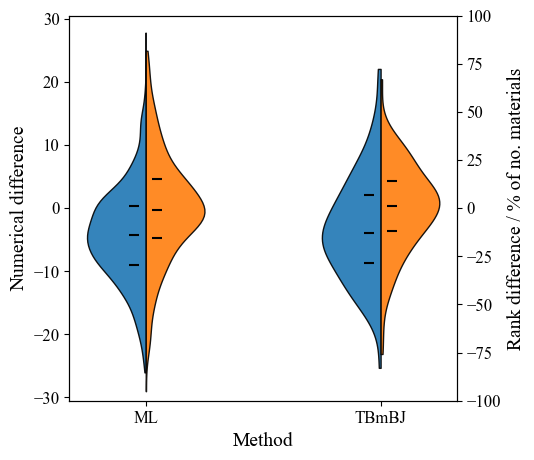

In [ ]:
fab_eta_dv= list(fab_eta_dd.values())
fab_eta_rv = 100*np.array(list(fab_eta_rd.values()))/len(fab_eta_rd)

choud_diffs_v= list(choud_diffs.values())
choud_ranks_v = 100*np.array(list(choud_ranks.values()))/len(choud_ranks)

s_kwargs = {"s": 50, "marker": "_"}
v_kwargs = {"showextrema": False, "showmedians": False, "showmeans": False, "widths": 0.5}

# create the figure and the axes (left and right)
fig, ax1 = plt.subplots(figsize=(5,5))
ax2 = ax1.twinx()


#LHS of violin plots (axis 1)
ax1.set_ylabel('Numerical difference', color='k')
ax1.tick_params(axis='y', labelcolor='k')
custom_violin(ax1, fab_eta_dv, 0.25, 'C0', 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax1, choud_diffs_v, 1.25, 'C0', 'k', 0.9, side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)


# RHS of violin plots (axis 2)
ax2.set_ylabel('Rank difference / % of no. materials', color='k')
ax2.tick_params(axis='y', labelcolor='k')
custom_violin(ax2, fab_eta_rv, 0.25, 'C1', 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
custom_violin(ax2, choud_ranks_v, 1.25, 'C1', 'k', 0.9, side="right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
ax2.set_ylim(-100,100)



# set the x-axis tick locations and labels
ax1.set_xticks([0.25, 1.25])
ax1.set_xticklabels(['ML', 'TBmBJ'])
ax1.set_xlabel('Method')
#ax1.set_title('Different methods for estimating SLME compared to Fabini data')

# adjust the position of the axes
org1 = 0.0  # Origin of first axis
org2 = 0.0  # Origin of second axis
pos = 0.5  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)

#ax1.axvline(x=0.25,color='r',linestyle='--') idea to show vertical lines to indicate e.g. the peak height of half the population to give a sense of relative heights of peaks

plt.savefig('functionals_violin.pdf',bbox_inches='tight')
plt.savefig('functionals_violin.svg',bbox_inches='tight')

In [ ]:
np.mean(np.abs(fab_eta_dv)),np.mean(np.abs(choud_diffs_v))

(6.8092244006498674, 7.205889102766991)

In [ ]:
np.mean(np.abs(fab_eta_rv)),np.mean(np.abs(choud_ranks_v))

(21.016634567100805, 17.68309925534923)

In [ ]:
len(choud_ranks_v), len(fab_eta_rv)

(103, 687)